**Import library**

In [ ]:
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 7.2 MB/s 


In [ ]:
import tensorflow as tf
Model = tf.keras.models.Model
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau
load_model = tf.keras.models.load_model

from pythainlp.tokenize import word_tokenize, Tokenizer
KRTokenizer = tf.keras.preprocessing.text.Tokenizer

pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd 

import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Define constant value for model**

In [ ]:
EPOCHS = 1500
BS = 32
DIMENSION = 100

**Read data from each dataset**

In [ ]:
df_kplus = pd.read_csv('/content/KPlus_Googleplay.csv')
df_scb = pd.read_csv('/content/SCB_Easy_Googleplay_cut.csv')
df_ktb = pd.read_csv('/content/Krungthai_next_Googleplay.csv')

**Remove some column from Kplus dataset**

In [ ]:
df_kplus.head(4)

reviewId               userName  \
0  9f20248d-8b73-408e-8e06-5556e5e342ad   นายมงคล เขียวบุญแย้ม   
1  864104fc-01d0-4a44-835d-f1ae41031bfd  Punpun aoorza Goodnow   
2  8f8e9708-35aa-425d-b044-17acfa120fa2             PalmZer Ch   
3  1225a715-8ad3-4093-90b8-71b3eeaeb7c7  ปรินทร์พร ทิพย์สุวรรณ   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a/ALm5wu...   
1  https://play-lh.googleusercontent.com/a-/ACNPE...   
2  https://play-lh.googleusercontent.com/a-/ACNPE...   
3  https://play-lh.googleusercontent.com/a-/ACNPE...   

                                             content  score  thumbsUpCount  \
0                                   ชอบแอบนี้มากๆ5.5      5              0   
1  ใช้มาตลอดพออัพเดทล่าสุดนี่เข้าไม่ได้เลยและเด้ง...      2              0   
2  ช่วงนี้แอปชอบเปิดเอง ทั้งๆที่ไม่ได้ใช้ ขึ้นมาข...      3              0   
3  ช่วงนี้แอฟเด้งมาบ่อยเลยค่ะ ในขณะที่ใช้แอฟอื่นอ...      2              0   

  reviewCreatedVersion                   at  \
0                  NaN  2022-11-12 06:13:13   
1               5.16.3  2022-11-12 06:07:28   
2               5.16.3  2022-11-12 04:54:49   
3               5.16.3  2022-11-12 04:39:23   

                                        replyContent            repliedAt  \
0  ขอขอบคุณ ที่ไว้วางใจใช้บริการ K PLUS ของธนาคาร...  2022-11-12 13:47:24   
1  ขออภัยในความไม่สะดวกที่ได้รับค่ะ เบื้องต้นรบกว...  2022-11-12 13:47:10   
2  ขออภัยในความไม่สะดวกที่ได้รับนะคะ หากพบปัญหากา...  2022-11-12 16:28:57   
3  ขออภัยในความไม่สะดวกที่ได้รับนะคะ เบื้องต้นรบก...  2022-11-12 16:28:47   

  Class  
0   pos  
1   neg  
2   neg  
3   neg

In [ ]:
df_kplus.rename(columns = {'at':'timestamp', 'Class':'class'}, inplace = True)
kplus_remove_columns = ['reviewId', 'userName','userImage','replyContent','repliedAt']
df_kplus.drop(kplus_remove_columns, axis=1, inplace=True)

In [ ]:
df_kplus.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Remove some column from SCB dataset**

In [ ]:
df_scb.head(4)

reviewId                userName  \
0  bb808b6e-7b5f-4708-9cf0-cce451e6b78b                ใหม ใหม่   
1  00475d91-ada3-4416-b84d-6e66c8b18f2b             ความลับในใจ   
2  11a3b575-57a5-4922-98b7-1d1e85c27a57  นางสาวชนานุช ดอกประทุม   
3  cf0553f1-6bcf-499f-82e3-13757311f66e     SuKuRuLo KoHeJiNaTo   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ACNPE...   
1  https://play-lh.googleusercontent.com/a-/ACNPE...   
2  https://play-lh.googleusercontent.com/a/ALm5wu...   
3  https://play-lh.googleusercontent.com/a/ALm5wu...   

                                          content  score  thumbsUpCount  \
0           ขยันอัปเดตจัง แต่!!ไม่มีอะไรดีขึ้นเลย    1.0            0.0   
1                                          เยี่ยม    5.0            0.0   
2           ไม่สามารถโหลดเพื่ออัพเดทแอปได้เมมเต็ม    5.0            0.0   
3  แอปเป็นอะไรวะทำไทถึงเข้าไม่ได้อ่า แก้ไขหน่อยนะ    1.0            0.0   

  reviewCreatedVersion                   at  replyContent  repliedAt Score  
0               3.56.0  2022-11-12 14:47:24           NaN        NaN   neg  
1               3.56.0  2022-11-12 13:38:43           NaN        NaN   neg  
2               3.56.0  2022-11-12 13:06:09           NaN        NaN   neg  
3               3.56.0  2022-11-12 13:05:33           NaN        NaN   neg

In [ ]:
df_scb.rename(columns = {'at':'timestamp', 'Score':'class'}, inplace = True)
scb_remove_columns = ['reviewId', 'userName','userImage','replyContent','repliedAt']
df_scb.drop(kplus_remove_columns, axis=1, inplace=True)

In [ ]:
df_scb.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Remove some column from KTB dataset**

In [ ]:
df_ktb.head(4)

reviewId            userName  \
0  bdfd375a-701e-4bc4-a5ff-ac1405a4f063      สุริยา ณ.สมุทร   
1  9181b9cf-bc01-4b90-bc65-aa67ae5ebb81      Jumlean Luecha   
2  f14a5783-0f0f-4c1c-b9d4-7ea0d78f52cf    SAMLEE TRUDMAKKA   
3  3ad1db88-f0c1-4e0f-8853-92352f070acc  มาหามะรอมือลี เห็ง   

                                           userImage                  content  \
0  https://play-lh.googleusercontent.com/a-/ACNPE...                       ดี   
1  https://play-lh.googleusercontent.com/a/ALm5wu...                     Good   
2  https://play-lh.googleusercontent.com/a/ALm5wu...  ให้บริการดีขอบคุณมากค่ะ   
3  https://play-lh.googleusercontent.com/a/ALm5wu...                     รุ่.   

   score  thumbsUpCount reviewCreatedVersion           Time Stamp Label  \
0      5              0               11.9.1  2022-11-12 07:17:54   pos   
1      5              0               11.9.1  2022-11-12 06:53:18   pos   
2      5              0               11.9.1  2022-11-12 06:50:52   pos   
3      4              0               11.6.3  2022-11-12 06:27:40     ?   

   Unnamed: 9  
0         NaN  
1         NaN  
2         NaN  
3         NaN

In [ ]:
df_ktb.rename(columns = {'Time Stamp':'timestamp', 'Label':'class'}, inplace = True)
ktb_remove_columns = ['reviewId', 'userName','userImage','Unnamed: 9']
df_ktb.drop(ktb_remove_columns, axis=1, inplace=True)

In [ ]:
df_ktb.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Merged dataset into dataframe**

In [ ]:
df = pd.concat([df_kplus, df_scb, df_ktb], ignore_index=True, sort=False)

In [ ]:
df.head()

content  score  thumbsUpCount  \
0                                   ชอบแอบนี้มากๆ5.5    5.0            0.0   
1  ใช้มาตลอดพออัพเดทล่าสุดนี่เข้าไม่ได้เลยและเด้ง...    2.0            0.0   
2  ช่วงนี้แอปชอบเปิดเอง ทั้งๆที่ไม่ได้ใช้ ขึ้นมาข...    3.0            0.0   
3  ช่วงนี้แอฟเด้งมาบ่อยเลยค่ะ ในขณะที่ใช้แอฟอื่นอ...    2.0            0.0   
4                                                 ดี    5.0            0.0   

  reviewCreatedVersion            timestamp class  
0                  NaN  2022-11-12 06:13:13   pos  
1               5.16.3  2022-11-12 06:07:28   neg  
2               5.16.3  2022-11-12 04:54:49   neg  
3               5.16.3  2022-11-12 04:39:23   neg  
4               5.16.3  2022-11-12 04:34:57   pos

**Check data type**

In [ ]:
df.dtypes

content                  object
score                   float64
thumbsUpCount           float64
reviewCreatedVersion     object
timestamp                object
class                    object
dtype: object

**Check null value and clean column**

In [ ]:
df.isnull().sum()

content                   1
score                     1
thumbsUpCount             1
reviewCreatedVersion    751
timestamp                 1
class                     8
dtype: int64

In [ ]:
df['content'] = df['content'].astype('str') 
df['content'] = df['content'].replace(np.nan,"")

In [ ]:
df['score'] = df['score'].replace(np.nan,0)

In [ ]:
df['thumbsUpCount'] = df['thumbsUpCount'].replace(np.nan,0)

In [ ]:
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].astype('str') 
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].replace("nan","0.0.0")
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].replace("","0.0.0")

In [ ]:
df['timestamp'] = df['timestamp'].astype('str') 
df['timestamp'] = df['timestamp'].replace(np.nan,"")

In [ ]:
df['class'].value_counts()

pos    1800
neg    1522
?       214
xxx       6
Name: class, dtype: int64

In [ ]:
df['class'] = df['class'].astype('str') 
df['class'] = df['class'].replace("nan","?")
df['class'] = df['class'].replace("xxx","?")

In [ ]:
df['class'].value_counts()

pos    1800
neg    1522
?       228
Name: class, dtype: int64

In [ ]:
df.isnull().sum()

content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
timestamp               0
class                   0
dtype: int64

**From above class value count**

* We should sample class with equal row number. (pos=1522, neg=1522)
* For alternative class("?"), predict in next model

In [ ]:
pos_df = df[df['class'] == "pos"].sample(1522, random_state = 42)
pos_df

content  score  thumbsUpCount reviewCreatedVersion  \
3110                  ถูกใจ    5.0            0.0               11.9.1   
1756            ใช้ด้ดีมากๆ    5.0            0.0               3.60.0   
1641            สดวกใช้ง่าย    5.0            0.0               3.60.0   
293                      ดี    5.0            0.0               5.16.1   
2335  ฉันชอบมากทุกวัน❤️❤️❤️    5.0            1.0               3.59.0   
...                     ...    ...            ...                  ...   
3516             ขอบคุณครับ    5.0            0.0               11.9.1   
3339              ใช้แล้วดี    3.0            0.0               11.8.1   
1017        ยอดเยี่ยมชอบมาก    5.0            0.0               5.16.1   
1731                  ดีมาก    5.0            0.0               3.60.0   
912                      ดี    1.0            0.0                0.0.0   

                timestamp class  
3110  2022-10-25 07:29:15   pos  
1756  2022-10-31 06:56:03   pos  
1641  2022-11-04 19:25:52   pos  
293   2022-11-06 18:19:54   pos  
2335  2022-10-07 05:03:46   pos  
...                   ...   ...  
3516  2022-10-11 10:17:21   pos  
3339  2022-10-18 12:54:47   pos  
1017  2022-10-22 10:45:54   pos  
1731  2022-10-31 22:57:43   pos  
912   2022-10-25 10:21:24   pos  

[1522 rows x 6 columns]

In [ ]:
neg_df = df[df['class'] == "neg"].sample(1522, random_state = 42)
neg_df

content  score  thumbsUpCount  \
1347                      พอจะรีบใช้งาน มีปัญหาทุกครั้ง    1.0            0.0   
2536  อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...    1.0            7.0   
3366       ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ    1.0            0.0   
2770  มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...    3.0            6.0   
2411                         อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒    2.0            0.0   
...                                                 ...    ...            ...   
2595                              ห่วยแตกโอนเงินไม่เข้า    1.0            0.0   
3043  สิ้นเดือนมีปัญหาตลอด ทำไมไม่เคยหาทางแก้ไขเนี่ย...    1.0            0.0   
2143  และ app เป็นไรชอบล่มตอน 23:00 น กับเที่ยงคืนแล...    1.0            0.0   
3329  แย่ชิปหาย ปรุงเถอะ เวลาเปลี่ยนเครื่องยังต้องแส...    1.0            6.0   
2586                                        มีปันหาตลอด    1.0            0.0   

     reviewCreatedVersion            timestamp class  
1347               5.16.1  2022-10-16 10:02:21   neg  
2536               3.59.0  2022-09-30 07:32:45   neg  
3366               11.9.1  2022-10-17 14:05:44   neg  
2770               11.9.1  2022-11-03 03:47:13   neg  
2411                0.0.0  2022-10-04 11:40:20   neg  
...                   ...                  ...   ...  
2595                0.0.0  2022-11-11 00:28:13   neg  
3043               11.9.1  2022-10-25 08:52:53   neg  
2143                0.0.0  2022-10-12 18:49:26   neg  
3329               11.9.1  2022-10-19 01:49:12   neg  
2586               11.9.1  2022-11-11 04:47:34   neg  

[1522 rows x 6 columns]

In [ ]:
unknown_df = df[df['class'] == "?"]
unknown_df

content  score  thumbsUpCount  \
84                                CC6844421    5.0            0.0   
94                                    ิอิอิ    5.0            0.0   
144                                  i ij!!    3.0            0.0   
147                                      ดี    4.0            0.0   
164                                      ~ช    5.0            0.0   
...                                     ...    ...            ...   
3524                        กู้เงินสินเชื่อ    4.0            0.0   
3526                             ลองใช้ก่อน    1.0            0.0   
3527  11/10/22 09:00-09:46เข้าแอพไม่ได้ครับ    3.0            0.0   
3541                                  ตคคตจ    4.0            0.0   
3544                    นะภถถภภภถนะภถถภภภถภ    2.0            0.0   

     reviewCreatedVersion            timestamp class  
84                 5.16.3  2022-11-10 18:04:18     ?  
94                 5.16.3  2022-11-10 14:18:38     ?  
144                5.16.1  2022-11-09 19:25:31     ?  
147                 0.0.0  2022-11-09 15:16:32     ?  
164                5.16.1  2022-11-09 10:29:10     ?  
...                   ...                  ...   ...  
3524                0.0.0  2022-10-11 05:17:39     ?  
3526                0.0.0  2022-10-11 04:44:04     ?  
3527               11.5.5  2022-10-11 02:46:25     ?  
3541               11.9.1  2022-10-10 09:51:25     ?  
3544               11.8.1  2022-10-10 08:46:48     ?  

[228 rows x 6 columns]

**Text PreProcessing**
*   Change Case
*   Removing Punctuations
*   Change Custom Words
*   Tokenization
*   Removing Stop Words
*   Change Correct Words


In [ ]:
sentiment_df = pd.concat([neg_df, pos_df])
sentiment_df

content  score  thumbsUpCount  \
1347                      พอจะรีบใช้งาน มีปัญหาทุกครั้ง    1.0            0.0   
2536  อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...    1.0            7.0   
3366       ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ    1.0            0.0   
2770  มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...    3.0            6.0   
2411                         อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒    2.0            0.0   
...                                                 ...    ...            ...   
3516                                         ขอบคุณครับ    5.0            0.0   
3339                                          ใช้แล้วดี    3.0            0.0   
1017                                    ยอดเยี่ยมชอบมาก    5.0            0.0   
1731                                              ดีมาก    5.0            0.0   
912                                                  ดี    1.0            0.0   

     reviewCreatedVersion            timestamp class  
1347               5.16.1  2022-10-16 10:02:21   neg  
2536               3.59.0  2022-09-30 07:32:45   neg  
3366               11.9.1  2022-10-17 14:05:44   neg  
2770               11.9.1  2022-11-03 03:47:13   neg  
2411                0.0.0  2022-10-04 11:40:20   neg  
...                   ...                  ...   ...  
3516               11.9.1  2022-10-11 10:17:21   pos  
3339               11.8.1  2022-10-18 12:54:47   pos  
1017               5.16.1  2022-10-22 10:45:54   pos  
1731               3.60.0  2022-10-31 22:57:43   pos  
912                 0.0.0  2022-10-25 10:21:24   pos  

[3044 rows x 6 columns]

Change Case

In [ ]:
sentiment_df['clean_comments'] = sentiment_df['content'].fillna('').apply(lambda x: x.lower())
sentiment_df.head()

content  score  thumbsUpCount  \
1347                      พอจะรีบใช้งาน มีปัญหาทุกครั้ง    1.0            0.0   
2536  อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...    1.0            7.0   
3366       ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ    1.0            0.0   
2770  มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...    3.0            6.0   
2411                         อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒    2.0            0.0   

     reviewCreatedVersion            timestamp class  \
1347               5.16.1  2022-10-16 10:02:21   neg   
2536               3.59.0  2022-09-30 07:32:45   neg   
3366               11.9.1  2022-10-17 14:05:44   neg   
2770               11.9.1  2022-11-03 03:47:13   neg   
2411                0.0.0  2022-10-04 11:40:20   neg   

                                         clean_comments  
1347                      พอจะรีบใช้งาน มีปัญหาทุกครั้ง  
2536  อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...  
3366       ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ  
2770  มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...  
2411                         อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒

Removing Punctuations

In [ ]:
pun = '"#\'()*,-.;<=>[\\]^_`{|}~'
pun

'"#\'()*,-.;<=>[\\]^_`{|}~'

In [ ]:
sentiment_df['clean_comments'] = sentiment_df['clean_comments'].str.replace(r'[%s]' % (pun), '', regex=True)
sentiment_df.sample(5)

content  score  thumbsUpCount  \
2983                                               ห่วย    1.0            0.0   
1143                                            เยี่ยม​    1.0            0.0   
781                                      มีปัญหาเยอะมาก    1.0            0.0   
2629  ทำไม? อัปเดตแล้ว เข้ารหัสในแอปได้ปกติ แต่ ขึ้น...    1.0            0.0   
456                                            ดีมากคัพ    5.0            0.0   

     reviewCreatedVersion            timestamp class  \
2983               11.9.1  2022-10-26 06:27:46   neg   
1143                0.0.0  2022-10-19 16:52:25   pos   
781                5.15.8  2022-10-28 14:59:25   neg   
2629               11.9.1  2022-11-09 15:15:23   neg   
456                5.16.1  2022-11-04 16:23:46   pos   

                                         clean_comments  
2983                                               ห่วย  
1143                                            เยี่ยม​  
781                                      มีปัญหาเยอะมาก  
2629  ทำไม? อัปเดตแล้ว เข้ารหัสในแอปได้ปกติ แต่ ขึ้น...  
456                                            ดีมากคัพ

Custom word

In [ ]:
THAI_CUSTOM_WORDS = '/content/thai_custom_words2.txt'
THAI_CORRECT_WORDS = '/content/thai_correct_words.txt'

In [ ]:
with open(THAI_CUSTOM_WORDS, encoding='utf8') as f:
    words = [line.strip() for line in f]

words

['เคแบง',
 'เคแบงก์',
 'Kplus',
 'กรุงไทย',
 'เคพลัส',
 'เคพัส',
 'K PLUS',
 'KPLUS',
 'k plus',
 'SCB',
 'ไทยพานิต',
 'คิวอาร์โค้ด',
 'กสิกรไทย',
 'คิวอาร์',
 'รีบูต',
 'ดีเลย์',
 'แอปพลิเคชัน',
 'แอป',
 'แอบ',
 'แอ๊ป',
 'แอฟ',
 'แอ้ป',
 'แอบ',
 'แอพ',
 'แอพปริชั่น',
 'เธ๊ออออ',
 'สดวก',
 'ก้อ',
 'ใด้',
 'จังกวะ',
 'หร้า',
 'เปยี่ยน',
 'เป้น',
 'บันชี',
 'บัชชี',
 'โคต',
 'โครต',
 'ไห้',
 'อารมย์',
 'สะดววก',
 'ธนาคาน',
 'รำคาน',
 'สามรถ',
 'คัฟ',
 'อัพเดต',
 'อัพเดท',
 'อัพเดท',
 'อัปเดท',
 'อัทเดท',
 'ครัย',
 'เรย',
 'งา่ย',
 'จัย',
 'ระหัส',
 'มรึง',
 'ธนาคาา',
 'ธนคาร',
 'บรืการ']

In [ ]:
custom_words_list = set(thai_words())
len(custom_words_list)

62055

In [ ]:
custom_words_list.update(words)
len(custom_words_list)

62099

Tokenization

In [ ]:
custom_tokenizer = Tokenizer(custom_words_list)

In [ ]:
sentiment_df['clean_comments'] = sentiment_df['clean_comments'].apply(lambda x: custom_tokenizer.word_tokenize(x))

In [ ]:
sentiment_df.sample(5)

content  score  thumbsUpCount  \
3151                                   แอปโหลดยากมากเลย    3.0            0.0   
2514  จำได้ว่าเคยให้คะแนนแอปดีมาก แต่ตอนนี้คงติดลบแอ...    1.0            6.0   
1517                                  เหนื่อยกับแอ้ปเธอ    1.0            0.0   
679                                เข้ายากเข้าเย็นจริงๆ    1.0            0.0   
122   เข้าได้แต่พอกดออกจากระบบจะขึ้นerror 105 พอปัดห...    3.0            1.0   

     reviewCreatedVersion            timestamp class  \
3151               11.9.1  2022-10-24 05:39:12   neg   
2514               3.59.0  2022-10-01 04:12:17   neg   
1517               3.56.0  2022-11-12 02:04:43   neg   
679                5.16.1  2022-10-31 01:45:51   neg   
122                5.16.3  2022-11-10 05:28:51   neg   

                                         clean_comments  
3151                         [แอป, โหลด, ยาก, มาก, เลย]  
2514  [จำได้, ว่า, เคย, ให้คะแนน, แอป, ดีมาก,  , แต่...  
1517                          [เหนื่อย, กับ, แอ้ป, เธอ]  
679                      [เข้า, ยาก, เข้า, เย็น, จริงๆ]  
122   [เข้า, ได้, แต่, พอ, กด, ออกจาก, ระบบ, จะ, ขึ้...

In [ ]:
tokenized_doc = sentiment_df['clean_comments']
tokenized_doc[:10]

1347          [พอ, จะ, รีบ, ใช้งาน,  , มีปัญหา, ทุกครั้ง]
2536    [อัปเดต, แทนที่, แอพพลิเคชัน, จะ, ดีกว่า, เดิม...
3366    [ทำ, มัย, เบอร์, ต้อง, ตรงเวลา, สำคัญ, ทำ, ไม่...
2770    [มีปัญหา, อยู่, อย่างหนึ่ง, และ, ก้เปน, อยู่, ...
2411           [อยู่ดีๆ, แอป, ก้อ, ล็อค, เอง, เฉย,  , 😒😒]
1054    [ใช้, ยุ่งยาก, ชิบหาย,  , บาง, คนใช้, รายเดือน...
2134    [ทำไม, ต้อง, ติดต่อ, ธนาคาร, ครับ, เข้าไป, แล้...
3440                                [ระบบ, ช้า, มาก, ค่ะ]
2447    [แอป, มี, ปัญญา, หา, อะไร, หนักหนา, ครับ, ล่ม,...
2514    [จำได้, ว่า, เคย, ให้คะแนน, แอป, ดีมาก,  , แต่...
Name: clean_comments, dtype: object

Delete english stop word

In [ ]:
 tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
 tokenized_doc[:10]

1347          [พอ, จะ, รีบ, ใช้งาน,  , มีปัญหา, ทุกครั้ง]
2536    [อัปเดต, แทนที่, แอพพลิเคชัน, จะ, ดีกว่า, เดิม...
3366    [ทำ, มัย, เบอร์, ต้อง, ตรงเวลา, สำคัญ, ทำ, ไม่...
2770    [มีปัญหา, อยู่, อย่างหนึ่ง, และ, ก้เปน, อยู่, ...
2411           [อยู่ดีๆ, แอป, ก้อ, ล็อค, เอง, เฉย,  , 😒😒]
1054    [ใช้, ยุ่งยาก, ชิบหาย,  , บาง, คนใช้, รายเดือน...
2134    [ทำไม, ต้อง, ติดต่อ, ธนาคาร, ครับ, เข้าไป, แล้...
3440                                [ระบบ, ช้า, มาก, ค่ะ]
2447    [แอป, มี, ปัญญา, หา, อะไร, หนักหนา, ครับ, ล่ม,...
2514    [จำได้, ว่า, เคย, ให้คะแนน, แอป, ดีมาก,  , แต่...
Name: clean_comments, dtype: object

Delete thai stop word

In [ ]:
 th_stop_words = list(thai_stopwords())
 tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in th_stop_words])

In [ ]:
 tokenized_doc[:10]

1347                            [รีบ, ใช้งาน,  , มีปัญหา]
2536    [อัปเดต, แทนที่, แอพพลิเคชัน, ดีกว่า, เดิม, อั...
3366                [ทำ, มัย, เบอร์, ตรงเวลา, ทำ, แย่มาก]
2770    [มีปัญหา, ก้เปน, เวลา, โอน, เสด, สลิป, ภาพ, หา...
2411                     [อยู่ดีๆ, แอป, ก้อ, ล็อค,  , 😒😒]
1054    [ยุ่งยาก, ชิบหาย,  , คนใช้, รายเดือน,  , เติม,...
2134     [ติดต่อ, ธนาคาร, เข้าไป, แล้วก็, ติดต่อ, ธนาคาร]
3440                                               [ระบบ]
2447    [แอป, ปัญญา, หา, หนักหนา, ล่ม, หยุด, จ่าย, ลูก...
2514    [จำได้, ให้คะแนน, แอป, ดีมาก,  , ตอนนี้, ติดลบ...
Name: clean_comments, dtype: object

Correct Word

In [ ]:
with open(THAI_CORRECT_WORDS) as f:
    thai_correct_word_list = [line.strip() for line in f]
    
thai_correct_word_list

['แอป แอปพลิเคชัน',
 'แอบ แอปพลิเคชัน',
 'แอ๊ป แอปพลิเคชัน',
 'แอฟ แอปพลิเคชัน',
 'แอ้ป แอปพลิเคชัน',
 'แอบ แอปพลิเคชัน',
 'แอพ แอปพลิเคชัน',
 'แอพปริชั่น แอปพลิเคชัน',
 'เธ๊ออออ เธอ',
 'สดวก สะดวก',
 'ก้อ ก็',
 'ใด้ ได้',
 'จังกวะ จังหวะ',
 'หร้า หน้า',
 'เปยี่ยน เปลี่ยน',
 'เป้น เป็น',
 'บันชี บัญชี',
 'บัชชี บัญชี',
 'โคต โคตร',
 'โครต โคตร',
 'ไห้ ให้',
 'อารมย์ อารมณ์',
 'สะดววก สะดวก',
 'ธนาคาน ธนาคาร',
 'รำคาน รำคาญ',
 'สามรถ สามารถ',
 'คัฟ ครับ',
 'อัพเดต อัปเดต',
 'อัพเดท อัปเดต',
 'อัพเดท อัปเดต',
 'อัปเดท อัปเดต',
 'อัทเดท อัปเดต',
 'ครัย ครับ',
 'เรย เลย',
 'งา่ย ง่าย',
 'จัย ใจ',
 'ระหัส รหัส',
 'มรึง มึง',
 'ธนาคาา ธนาคาร',
 'ธนคาร ธนาคาร',
 'บรืการ บริการ']

In [ ]:
correct_pair={}

for pair in thai_correct_word_list:
    correct_pair[pair.split()[0].strip()]=pair.split()[1].strip() 

In [ ]:
doc = []
for tokenized_list in tokenized_doc:
    for index, word in enumerate(tokenized_list):
        if word in correct_pair:
            tokenized_list[index]=correct_pair[word]
    doc.append(tokenized_list)
    
tokenized_doc = pd.Series(doc)

In [ ]:
tokenized_doc

0                               [รีบ, ใช้งาน,  , มีปัญหา]
1       [อัปเดต, แทนที่, แอพพลิเคชัน, ดีกว่า, เดิม, อั...
2                   [ทำ, มัย, เบอร์, ตรงเวลา, ทำ, แย่มาก]
3       [มีปัญหา, ก้เปน, เวลา, โอน, เสด, สลิป, ภาพ, หา...
4                 [อยู่ดีๆ, แอปพลิเคชัน, ก็, ล็อค,  , 😒😒]
                              ...                        
3039                                             [ขอบคุณ]
3040                                        [ใช้แล้ว, ดี]
3041                                     [ยอดเยี่ยม, ชอบ]
3042                                              [ดีมาก]
3043                                                 [ดี]
Length: 3044, dtype: object

In [ ]:
tokenized_doc = tokenized_doc.to_list()

De-tokenization

In [ ]:
# de-tokenization
detokenized_doc = []
for i in range(len(tokenized_doc)):
#     print(tokenized_doc[i])
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
sentiment_df['clean_comments'] = detokenized_doc

In [ ]:
sentiment_df.head()

content  score  thumbsUpCount  \
1347                      พอจะรีบใช้งาน มีปัญหาทุกครั้ง    1.0            0.0   
2536  อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...    1.0            7.0   
3366       ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ    1.0            0.0   
2770  มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...    3.0            6.0   
2411                         อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒    2.0            0.0   

     reviewCreatedVersion            timestamp class  \
1347               5.16.1  2022-10-16 10:02:21   neg   
2536               3.59.0  2022-09-30 07:32:45   neg   
3366               11.9.1  2022-10-17 14:05:44   neg   
2770               11.9.1  2022-11-03 03:47:13   neg   
2411                0.0.0  2022-10-04 11:40:20   neg   

                                         clean_comments  
1347                               รีบ ใช้งาน   มีปัญหา  
2536  อัปเดต แทนที่ แอพพลิเคชัน ดีกว่า เดิม อัปเดต แ...  
3366                     ทำ มัย เบอร์ ตรงเวลา ทำ แย่มาก  
2770  มีปัญหา ก้เปน เวลา โอน เสด สลิป ภาพ หาย ภาพ คร...  
2411                   อยู่ดีๆ แอปพลิเคชัน ก็ ล็อค   😒😒

Split test data

In [ ]:
temp_df = sentiment_df

sentiment_df = temp_df.sample(2435, random_state = 42)
test_df = temp_df.sample(609, random_state = 42) #total 3044 rows, train 609 rows, test 2435 rows

In [ ]:
cleaned_words = sentiment_df['clean_comments'].to_list()

In [ ]:
cleaned_words[:1]

['สแกน ใบหน้า ดี ระบบ ปรับปรุง']

**Tokenization with keras (use vector result from keras)**

In [ ]:
def create_tokenizer(words, filters = ''):
    token = KRTokenizer()
    token.fit_on_texts(words)
    return token

In [ ]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1

train_word_tokenizer.word_index

{'แอปพลิเคชัน': 1,
 'ดี': 2,
 'ดีมาก': 3,
 'เงิน': 4,
 'โอน': 5,
 'ทำ': 6,
 '\u200b': 7,
 'ธนาคาร': 8,
 'ใช้งาน': 9,
 'อัปเดต': 10,
 'เด้ง': 11,
 'สะดวก': 12,
 'ระบบ': 13,
 'คับ': 14,
 'ชอบ': 15,
 'แย่มาก': 16,
 'ล่ม': 17,
 'ปรับปรุง': 18,
 'บริการ': 19,
 'มีปัญหา': 20,
 'แย่': 21,
 'กด': 22,
 'ห่วย': 23,
 'โหลด': 24,
 'ผม': 25,
 'สมัคร': 26,
 'บัญชี': 27,
 'เวลา': 28,
 'เครื่อง': 29,
 'จ่าย': 30,
 'สแกน': 31,
 'ตอนนี้': 32,
 'หน้า': 33,
 'ห่วยแตก': 34,
 'แจ้ง': 35,
 'app': 36,
 'ลบ': 37,
 'รอบ': 38,
 'คน': 39,
 'หาย': 40,
 'เยี่ยม': 41,
 'เตือน': 42,
 'งง': 43,
 'รายการ': 44,
 'ตัง': 45,
 'ด่วน': 46,
 'ติด': 47,
 'กก': 48,
 'ขอบคุณ': 49,
 'ค้าง': 50,
 'ง': 51,
 'เ': 52,
 'ข้อมูล': 53,
 'ดาว': 54,
 'ติดตั้ง': 55,
 'ok': 56,
 'กาก': 57,
 'โคตร': 58,
 'เน็ต': 59,
 'รู้': 60,
 'บัตร': 61,
 'ไม่ต้อง': 62,
 'แล้วก็': 63,
 'ใช้ไม่ได้': 64,
 'แบบนี้': 65,
 'นะคะ': 66,
 'เบอร์': 67,
 'ใบหน้า': 68,
 'ปัญหา': 69,
 'สุดยอด': 70,
 'good': 71,
 'กรุงไทย': 72,
 'กน': 73,
 'สะดวกสบาย': 74,
 'ต้องการ'

In [ ]:
tokenized_doc[:3]

[['รีบ', 'ใช้งาน', ' ', 'มีปัญหา'],
 ['อัปเดต',
  'แทนที่',
  'แอพพลิเคชัน',
  'ดีกว่า',
  'เดิม',
  'อัปเดต',
  'แย่',
  'ธนาคาร',
  'อัปเดต',
  'แอปพลิเคชัน',
  'แย่มาก',
  ' ',
  'มีธุระ',
  'เงิน',
  'แอพพลิเคชัน',
  'ใช้งาน',
  ' ',
  'พัฒนา',
  'อัปเดต',
  'แทนที่จะ',
  'ดีแต่',
  'แย่',
  'เก่า',
  ' ',
  'ระบบ',
  'มีปัญหา',
  'ไทย',
  'นิ',
  'ชย',
  '์',
  'ธนาคาร',
  'ดีกว่า',
  'เปรียบเทียบ',
  'แอพพลิเคชัน'],
 ['ทำ', 'มัย', 'เบอร์', 'ตรงเวลา', 'ทำ', 'แย่มาก']]

In [ ]:
def max_length(words):
    return(len(max(words, key = len)))

In [ ]:
max_length = max_length(tokenized_doc)
max_length

132

In [ ]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

In [ ]:
print(cleaned_words[0])
print(encoded_doc[0])

สแกน ใบหน้า ดี ระบบ ปรับปรุง
[31, 68, 2, 13, 18]


In [ ]:
def padding_doc(encoded_doc, max_length):
   return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

Shape of padded docs =  (2435, 132)
สแกน ใบหน้า ดี ระบบ ปรับปรุง
[31, 68, 2, 13, 18]
[31 68  2 13 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
category = sentiment_df['class'].to_list()

In [ ]:
unique_category = list(set(category))
unique_category

['neg', 'pos']

In [ ]:
output_tokenizer = create_tokenizer(unique_category)

In [ ]:
encoded_output = encoding_doc(output_tokenizer, category)
print(category[1:2])
print(encoded_output[1:2])

['pos']
[[2]]


In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(2435, 1)

In [ ]:
def one_hot(encode):
  oh = OneHotEncoder(sparse = False)
  return(oh.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[1]
[1. 0.]


**Train and validation split**

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1948, 132) and train_Y = (1948, 2)
Shape of val_X = (487, 132) and val_Y = (487, 2)


In [ ]:
num_classes = len(unique_category)

In [ ]:
num_classes

2

**Initial learning rate**

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)

**Define CNN model**

In [ ]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = tf.keras.layers.Input(shape=(length,))
    embedding1 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs1)
    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = tf.keras.layers.Dropout(0.5)(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop1)
    flat1 = tf.keras.layers.Flatten()(pool1)
    # channel 2
    inputs2 = tf.keras.layers.Input(shape=(length,))
    embedding2 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs2)
    conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = tf.keras.layers.Dropout(0.5)(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
    flat2 = tf.keras.layers.Flatten()(pool2)
    # channel 3
    inputs3 = tf.keras.layers.Input(shape=(length,))
    embedding3 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs3)
    conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = tf.keras.layers.Dropout(0.5)(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)
    flat3 = tf.keras.layers.Flatten()(pool3)
    # merge
    merged = tf.keras.layers.concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = tf.keras.layers.Dense(10, activation='relu')(merged)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    # summarize
    print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
vocab_size

2129

In [ ]:
model = define_model(max_length, vocab_size)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 132, 100)     212900      ['input_1[0][0]']                
                                                                                              

In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.1, min_lr=0.000001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [ ]:
hist = model.fit([train_X, train_X, train_X], train_Y, epochs = EPOCHS, batch_size = BS, validation_data = ([val_X, val_X, val_X], val_Y), callbacks = [callbacks_list], shuffle=True)

Streaming output truncated to the last 5000 lines.
Epoch 251/1500
60/61 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9792
Epoch 251: val_loss did not improve from 0.18934
61/61 [==============================] - 0s 6ms/step - loss: 0.0622 - accuracy: 0.9790 - val_loss: 0.1944 - val_accuracy: 0.9179 - lr: 1.0000e-06
Epoch 252/1500
58/61 [===========================>..] - ETA: 0s - loss: 0.0636 - accuracy: 0.9790
Epoch 252: val_loss did not improve from 0.18934
61/61 [==============================] - 0s 6ms/step - loss: 0.0644 - accuracy: 0.9790 - val_loss: 0.1947 - val_accuracy: 0.9179 - lr: 1.0000e-06
Epoch 253/1500
59/61 [============================>.] - ETA: 0s - loss: 0.0666 - accuracy: 0.9799
Epoch 253: val_loss did not improve from 0.18934
61/61 [==============================] - 0s 6ms/step - loss: 0.0649 - accuracy: 0.9805 - val_loss: 0.1946 - val_accuracy: 0.9179 - lr: 1.0000e-06
Epoch 254/1500
59/61 [============================>.] - ETA: 0s - loss

In [ ]:
h1 = go.Scatter(y=hist.history['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=hist.history['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
h1 = go.Scatter(y=hist.history['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=hist.history['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
predict_model = load_model(filename) 
predict_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 132, 100)     212900      ['input_1[0][0]']                
                                                                                              

In [ ]:
score = predict_model.evaluate([val_X, val_X, val_X], val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.18933767080307007
Validate accuracy: 0.9260780215263367


In [ ]:
predicted_classes = np.argmax(predict_model.predict([val_X, val_X, val_X]), axis=-1)
predicted_classes.shape

16/16 [==============================] - 0s 2ms/step


(487,)

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[0. 1.]
1


In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")

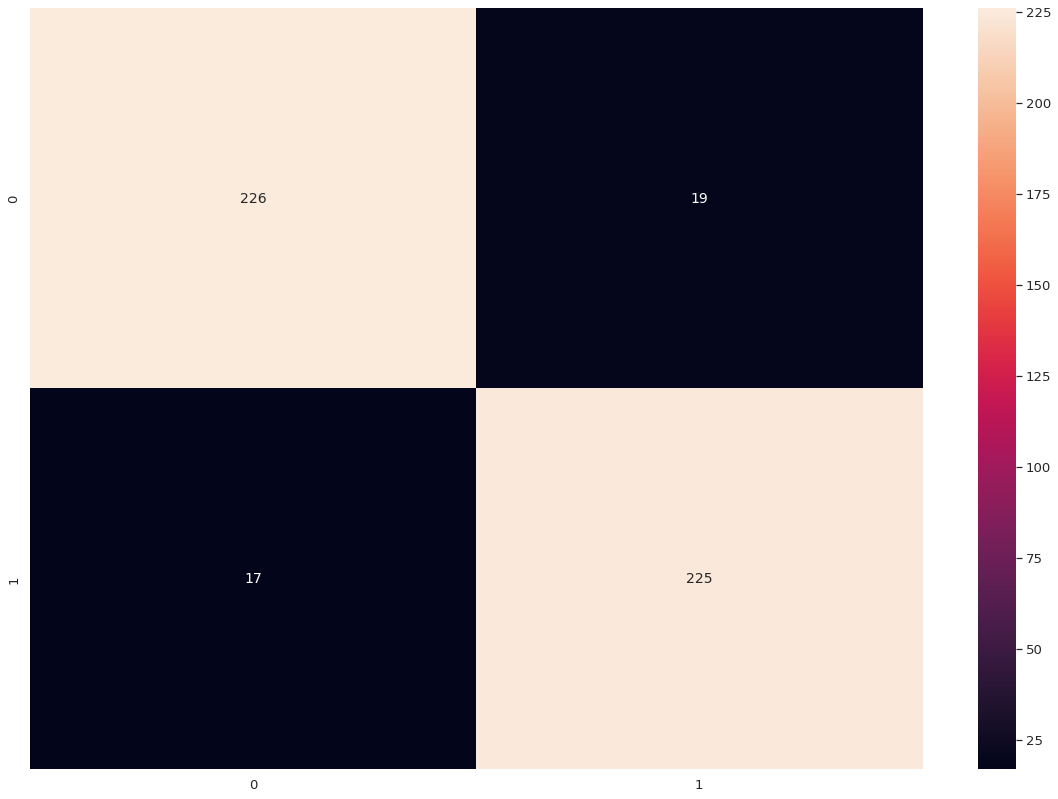

In [ ]:
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
label_dict = output_tokenizer.word_index

In [ ]:
label = [key for key, value in label_dict.items()]

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         neg     0.9300    0.9224    0.9262       245
         pos     0.9221    0.9298    0.9259       242

    accuracy                         0.9261       487
   macro avg     0.9261    0.9261    0.9261       487
weighted avg     0.9261    0.9261    0.9261       487



# CNN with word Embedding Gensim

In [ ]:
sentences = [st.split() for st in cleaned_words]

In [ ]:
EPOCHS_2 = 1500 

In [ ]:
w2v_model = Word2Vec(sentences, min_count=1, size=DIMENSION, workers=6, sg=1, iter=EPOCHS_2)

In [ ]:
w2v_model.save('w2v_model.bin')

In [ ]:
new_model = Word2Vec.load('w2v_model.bin')

In [ ]:
embedding_matrix = np.zeros((vocab_size, DIMENSION))

for word, i in train_word_tokenizer.word_index.items():
    if word in new_model.wv.vocab:
        embedding_vector = new_model.wv[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
# define the model
def define_w2v_model(length, vocab_size, embedding_matrix):
    # channel 1
    inputs1 = tf.keras.layers.Input(shape=(length,))
    embedding1 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = False, weights=[embedding_matrix])(inputs1)
    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = tf.keras.layers.Dropout(0.5)(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop1)
    flat1 = tf.keras.layers.Flatten()(pool1)
    # channel 2
    inputs2 = tf.keras.layers.Input(shape=(length,))
    embedding2 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = False, weights=[embedding_matrix])(inputs2)
    conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = tf.keras.layers.Dropout(0.5)(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
    flat2 = tf.keras.layers.Flatten()(pool2)
    # channel 3
    inputs3 = tf.keras.layers.Input(shape=(length,))
    embedding3 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = False, weights=[embedding_matrix])(inputs3)
    conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = tf.keras.layers.Dropout(0.5)(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)
    flat3 = tf.keras.layers.Flatten()(pool3)
    # merge
    merged = tf.keras.layers.concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = tf.keras.layers.Dense(10, activation='relu')(merged)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    # summarize
    print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
model2 = define_w2v_model(max_length, vocab_size, embedding_matrix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 132, 100)     212900      ['input_4[0][0]']                
                                                                                            

In [ ]:
filename = 'model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.1, min_lr=0.000001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [ ]:
hist2 = model2.fit([train_X, train_X, train_X], train_Y, epochs = EPOCHS_2, batch_size = BS, validation_data = ([val_X, val_X, val_X], val_Y), callbacks = [callbacks_list], shuffle=True)


Streaming output truncated to the last 5000 lines.
Epoch 251/1500
56/61 [==========================>...] - ETA: 0s - loss: 0.3853 - accuracy: 0.8237
Epoch 251: val_loss improved from 0.39785 to 0.39705, saving model to model2.h5
61/61 [==============================] - 0s 6ms/step - loss: 0.3869 - accuracy: 0.8239 - val_loss: 0.3970 - val_accuracy: 0.8275 - lr: 1.0000e-06
Epoch 252/1500
52/61 [========================>.....] - ETA: 0s - loss: 0.3856 - accuracy: 0.8245
Epoch 252: val_loss improved from 0.39705 to 0.39629, saving model to model2.h5
61/61 [==============================] - 0s 6ms/step - loss: 0.3859 - accuracy: 0.8275 - val_loss: 0.3963 - val_accuracy: 0.8275 - lr: 1.0000e-06
Epoch 253/1500
52/61 [========================>.....] - ETA: 0s - loss: 0.3770 - accuracy: 0.8287
Epoch 253: val_loss improved from 0.39629 to 0.39551, saving model to model2.h5
61/61 [==============================] - 0s 6ms/step - loss: 0.3818 - accuracy: 0.8270 - val_loss: 0.3955 - val_accuracy: 0

In [ ]:
h1 = go.Scatter(y=hist2.history['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=hist2.history['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
h1 = go.Scatter(y=hist2.history['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=hist2.history['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
predict_model2 = load_model(filename) 
predict_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 132, 100)     212900      ['input_4[0][0]']                
                                                                                            

In [ ]:
score = predict_model2.evaluate([val_X, val_X, val_X], val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.18052026629447937
Validate accuracy: 0.9178645014762878


In [ ]:
predicted_classes = np.argmax(predict_model2.predict([val_X, val_X, val_X]), axis=-1)
predicted_classes.shape

16/16 [==============================] - 0s 2ms/step


(487,)

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")

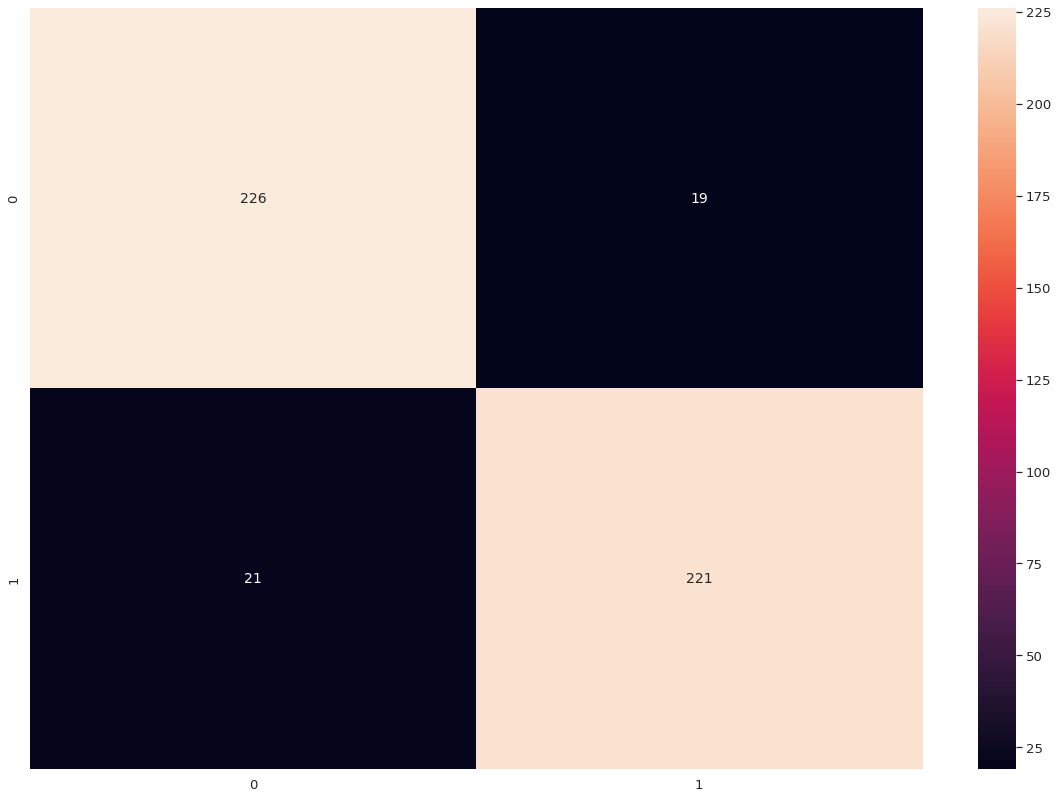

In [ ]:
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         neg     0.9150    0.9224    0.9187       245
         pos     0.9208    0.9132    0.9170       242

    accuracy                         0.9179       487
   macro avg     0.9179    0.9178    0.9179       487
weighted avg     0.9179    0.9179    0.9179       487



# Predict result from model1(CNN) and model2(CNN with Gensim)

**CNN model**

Prepare test data

In [ ]:
test_df.head()

content  score  thumbsUpCount  \
2748           สแกนใบหน้าไม่ดีระบบควรปรับปรุง    1.0            0.0   
2694                          ใช้งานสะดวกสบาย    5.0            0.0   
1931  แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​    1.0            0.0   
1575               ปิดปรับปรุงบ่อยมากคะแข้ไขั    3.0            0.0   
1934                               โหลดไม่ได้    5.0            0.0   

     reviewCreatedVersion            timestamp class  \
2748               11.9.1  2022-11-04 06:45:23   neg   
2694               11.9.1  2022-11-06 17:08:55   pos   
1931                0.0.0  2022-10-22 13:27:32   neg   
1575                0.0.0  2022-11-09 10:37:38   neg   
1934               3.59.0  2022-10-22 10:12:28   neg   

                        clean_comments  
2748      สแกน ใบหน้า ดี ระบบ ปรับปรุง  
2694                  ใช้งาน สะดวกสบาย  
1931  แย่มาก ​   ปรับปรุง ให้ ​ ค่าย ​  
1575                 ปรับปรุง แข้ ไข ั  
1934                              โหลด

In [ ]:
test_cleaned_words = test_df['clean_comments'].to_list()

In [ ]:
test_word_tokenizer = create_tokenizer(test_cleaned_words)

In [ ]:
test_encoded_doc = encoding_doc(test_word_tokenizer, test_cleaned_words)

In [ ]:
test_padded_doc = padding_doc(test_encoded_doc, max_length)
print("Shape of padded docs = ",test_padded_doc.shape)

print(test_cleaned_words[0])
print(test_encoded_doc[0])
print(test_padded_doc[0])

Shape of padded docs =  (609, 132)
สแกน ใบหน้า ดี ระบบ ปรับปรุง
[39, 47, 2, 12, 18]
[39 47  2 12 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
test_category = test_df['class'].to_list()

In [ ]:
test_unique_category = list(set(test_category))
test_unique_category

['neg', 'pos']

In [ ]:
test_output_tokenizer = create_tokenizer(test_unique_category)

In [ ]:
test_encoded_output = encoding_doc(test_output_tokenizer, test_category)
print(test_category[1:2])
print(test_encoded_output[1:2])

['pos']
[[2]]


In [ ]:
test_encoded_output = np.array(test_encoded_output).reshape(len(test_encoded_output), 1)
test_encoded_output.shape

(609, 1)

In [ ]:
test_output_one_hot = one_hot(test_encoded_output)
print(test_encoded_output[0])
print(test_output_one_hot[0])

[1]
[1. 0.]


In [ ]:
test_padded_doc

array([[ 39,  47,   2, ...,   0,   0,   0],
       [  9,  61,   0, ...,   0,   0,   0],
       [ 13,  19,  18, ...,   0,   0,   0],
       ...,
       [883,  27,  26, ...,   0,   0,   0],
       [  3,  18, 212, ...,   0,   0,   0],
       [199, 310, 885, ...,   0,   0,   0]], dtype=int32)

In [ ]:
predicted_classes_1 = np.argmax(predict_model.predict([test_padded_doc, test_padded_doc, test_padded_doc]), axis=-1)

20/20 [==============================] - 0s 15ms/step


In [ ]:
predicted_classes_1

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,

In [ ]:
def mapClassLabel(n):
    mapClassList = []
    for classVal in n:
      if (classVal == 0):
        mapClassList.append("neg")
      elif (classVal == 1):
        mapClassList.append("pos")
    return mapClassList     

In [ ]:
cate_predicted_classes_1 = mapClassLabel(predicted_classes_1)
# predicted_classes_1

In [ ]:
test_df["predict_class"] = np.array(cate_predicted_classes_1)

test_df.head()

content  score  thumbsUpCount  \
2748           สแกนใบหน้าไม่ดีระบบควรปรับปรุง    1.0            0.0   
2694                          ใช้งานสะดวกสบาย    5.0            0.0   
1931  แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​    1.0            0.0   
1575               ปิดปรับปรุงบ่อยมากคะแข้ไขั    3.0            0.0   
1934                               โหลดไม่ได้    5.0            0.0   

     reviewCreatedVersion            timestamp class  \
2748               11.9.1  2022-11-04 06:45:23   neg   
2694               11.9.1  2022-11-06 17:08:55   pos   
1931                0.0.0  2022-10-22 13:27:32   neg   
1575                0.0.0  2022-11-09 10:37:38   neg   
1934               3.59.0  2022-10-22 10:12:28   neg   

                        clean_comments predict_class  
2748      สแกน ใบหน้า ดี ระบบ ปรับปรุง           pos  
2694                  ใช้งาน สะดวกสบาย           neg  
1931  แย่มาก ​   ปรับปรุง ให้ ​ ค่าย ​           neg  
1575                 ปรับปรุง แข้ ไข ั           neg  
1934                              โหลด           pos

In [ ]:
y_true_1 = np.argmax(test_output_one_hot,axis = 1)
print(test_output_one_hot[0])
print(y_true_1[0])

[1. 0.]
0


In [ ]:
cm_cnn = confusion_matrix(y_true_1, predicted_classes_1)
np.savetxt("confusion_matrix_CNN.csv", cm_cnn, delimiter=",")

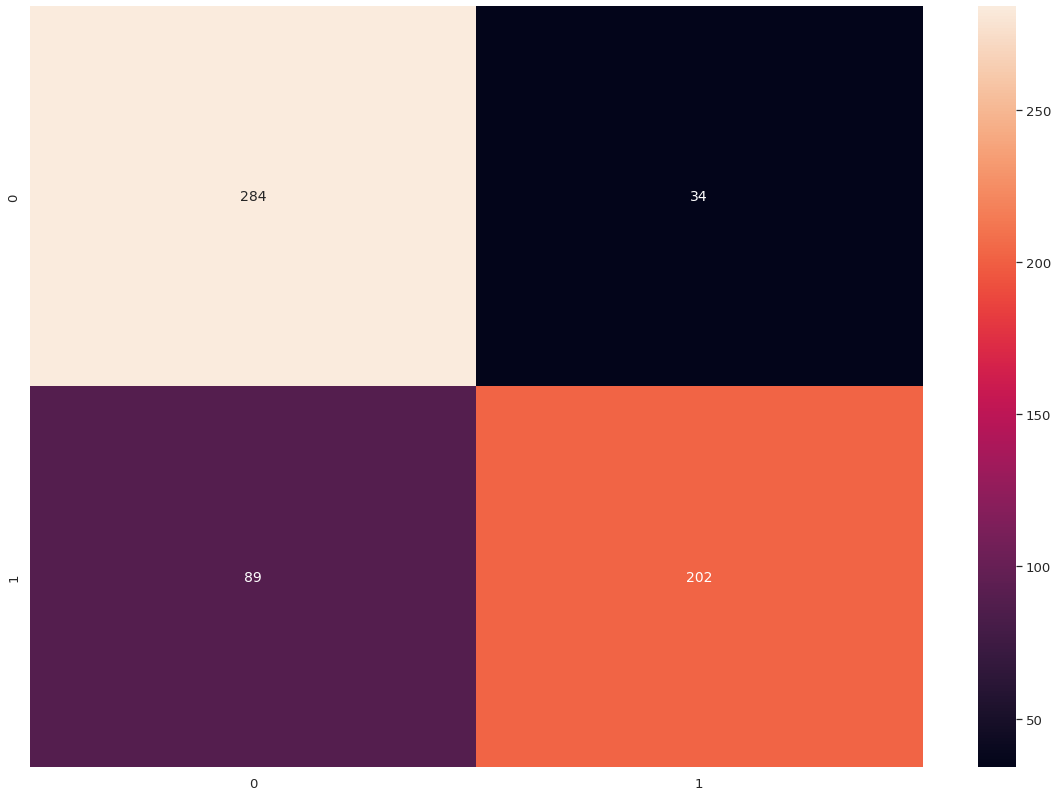

In [ ]:
test_df_cm_cnn = pd.DataFrame(cm_cnn, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(test_df_cm_cnn, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
label_test_dict = test_output_tokenizer.word_index

In [ ]:
label_test = [key for key, value in label_test_dict.items()]

In [ ]:
print(classification_report(y_true_1, predicted_classes_1, target_names=label_test, digits=4))

              precision    recall  f1-score   support

         neg     0.7614    0.8931    0.8220       318
         pos     0.8559    0.6942    0.7666       291

    accuracy                         0.7980       609
   macro avg     0.8087    0.7936    0.7943       609
weighted avg     0.8066    0.7980    0.7955       609



Predict label compare with actual comment score

In [ ]:
len(test_df)

609

In [ ]:
query = test_df.query("`score` >= 3 and `predict_class` == 'pos'")

len(query)

210

In [ ]:
query.sample(20)

content  score  thumbsUpCount reviewCreatedVersion  \
3226                    ขอบคุณค่ะ    5.0            0.0                0.0.0   
2954         ใช่มาตลอดเช่นกันครับ    5.0            0.0               11.9.1   
3153                สดวกดีมากครับ    5.0            0.0                0.0.0   
656                         ดีมาก    5.0            0.0               5.16.1   
1522       ดีมากๆๆ.เลยค่ะ.รักสุดๆ    5.0            0.0               3.56.0   
117                        เยี่ยม    5.0            0.0               5.16.3   
1431    รีวิวใช้ดีมากบริการกลับใจ    5.0            0.0               5.16.1   
1163                      ดี ครับ    5.0            0.0               5.16.1   
1607                        เี่ยม    5.0            0.0               3.60.0   
2574                       ดีครับ    5.0            0.0               11.9.1   
2403                     ใช่ดีมาก    5.0            0.0               3.58.0   
2292                    ดีมากครับ    5.0            0.0               3.59.0   
1877                           ดี    5.0            1.0               3.60.0   
1275                           ดี    5.0            0.0               5.16.1   
1437                       ดีครับ    5.0            0.0               5.16.1   
555                            ดี    5.0            1.0               5.16.1   
2953  สะดวกรวดเร็วและสบายยิ่งขื้น    5.0            0.0                0.0.0   
3319                โดยรวมok.ครับ    5.0            0.0               11.9.1   
456                      ดีมากคัพ    5.0            0.0               5.16.1   
643                     ดีมากครับ    5.0            0.0               5.16.1   

                timestamp class             clean_comments predict_class  
3226  2022-10-20 14:48:13   pos                     ขอบคุณ           pos  
2954  2022-10-27 05:15:06   pos                                      pos  
3153  2022-10-23 23:27:50   pos                สะดวก ดีมาก           pos  
656   2022-10-31 11:12:42   pos                      ดีมาก           pos  
1522  2022-11-12 00:46:13   pos               ดีมาก ๆๆ รัก           pos  
117   2022-11-10 06:23:33   pos                     เยี่ยม           pos  
1431  2022-10-14 06:42:44   pos  รีวิว ดีมาก บริการ กลับใจ           pos  
1163  2022-10-19 05:46:57   pos                       ดี             pos  
1607  2022-11-06 16:11:27   pos                      เี่ยม           pos  
2574  2022-11-11 11:08:35   pos                         ดี           pos  
2403  2022-10-05 01:39:28   pos                      ดีมาก           pos  
2292  2022-10-08 01:32:33   pos                      ดีมาก           pos  
1877  2022-10-25 06:03:58   pos                         ดี           pos  
1275  2022-10-17 14:03:38   pos                         ดี           pos  
1437  2022-10-14 04:59:13   pos                         ดี           pos  
555   2022-11-02 17:11:15   pos                         ดี           pos  
2953  2022-10-27 06:08:31   pos                 สะดวก ขื้น           pos  
3319  2022-10-19 08:24:38   pos                  โดยรวม ok           pos  
456   2022-11-04 16:23:46   pos                  ดีมาก คัพ           pos  
643   2022-10-31 18:28:56   pos                      ดีมาก           pos

In [ ]:
query = test_df.query("`score` < 3 and `predict_class` == 'neg'")

len(query)

219

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
1789  จากที่แคปหน้าจอหน้ายอดเงินได้ อยู่ๆแม่งก็แคปไม...    1.0            0.0   
1099  ช่วงนี้ทำไมอยู่ๆก็เด้งเข้าแอปเองครับ ปกติจะไม่...    1.0            1.0   
1165  ห่วยแตก มีข้อมูลแล้วจะล็อกอินเด้งให้กูสมัครใหม...    1.0            0.0   
3078                                               ห่วย    1.0            0.0   
1667                                  ทำไมเข้าแอฟไม่ได้    1.0            0.0   
414   แอพเข้าไม่ได้ ทำตามขั้นตอนท้ังหมดแล้ว ก็ยังเข้...    1.0            0.0   
1718                                           0ดาว แย่    1.0            0.0   
817   อัฟเดตช้ามากๆเลยครับใชังานแต่ละทีก็ต้องรอเป็นพ...    2.0            0.0   
2544  ระบบล่ม หรือทำธุรกรรมไม่ได้น่าจะแจ้งไว้สักหน่อ...    1.0            2.0   
1211  ปรับปรุงด้วยนะคะพออัปเดตแล้วมันก็เด้งออกบ่อยมา...    1.0            0.0   
2203                               ทำไมอัปเดตไม่ได้..งง    2.0            0.0   
20    ห่วยจัด เงินเขาไม่แจ้งเตือนช้า พอกดเข้าแอปให้ ...    1.0            0.0   
2508                    แอปมีปัญหาบ่อยสแกนโอนเงินไม่ได้    1.0            0.0   
2522                           โอนเงินออกจากบัญชีไม่ได้    1.0            0.0   
2874                 ห่วย โทรคอลเซ็นเตอก็ช่วยอะไรไม่ได้    1.0            0.0   
725   ล่มอะไรนักหนา คนเขาต้องการใช้เงินแล้วนี่ไม่พกเ...    1.0            0.0   
3427       เเก้ไขด้วยค่ะ ดูหน้าสมุดบัญชีในเเอพไม่ได้ค่ะ    2.0            0.0   
793   คือแย่มากปกติก็มีแอปยู่นะแต่พอเราเปลี่ยนเครื่อ...    1.0            0.0   
2738  เบอร์เก่าที่ลงทะเบียนไว้ไม่ได้ใช้จะเปลื่ยนเบอร...    1.0            0.0   
3344  กากอีสัส โอนตัวเข้ามาแล้ว ตังไม่ขึ้น อย่างกาก ...    1.0            0.0   

     reviewCreatedVersion            timestamp class  \
1789               3.60.0  2022-10-29 15:30:15   neg   
1099               5.16.1  2022-10-20 14:47:38   neg   
1165               5.16.1  2022-10-19 05:32:21   neg   
3078                0.0.0  2022-10-25 08:01:41   neg   
1667               3.60.0  2022-11-03 06:17:02   neg   
414                5.16.2  2022-11-05 06:32:25   neg   
1718               3.53.0  2022-11-01 08:59:35   neg   
817                5.16.1  2022-10-27 21:38:47   neg   
2544               3.59.0  2022-09-30 07:28:31   neg   
1211                0.0.0  2022-10-18 12:03:24   neg   
2203               3.54.0  2022-10-10 08:36:47   neg   
20                 5.13.0  2022-11-12 00:23:49   neg   
2508               3.59.0  2022-10-01 06:58:26   neg   
2522                0.0.0  2022-09-30 15:08:32   neg   
2874               11.9.1  2022-10-30 12:16:07   neg   
725                5.16.1  2022-10-30 01:43:45   neg   
3427               11.9.1  2022-10-15 07:09:54   neg   
793                5.16.1  2022-10-28 10:55:41   neg   
2738                0.0.0  2022-11-04 17:29:51   neg   
3344               11.9.1  2022-10-18 07:20:23   neg   

                                         clean_comments predict_class  
1789  แคป หน้าจอ หน้า ยอด เงินได้   แม่ ง แคป   แล้ ...           neg  
1099  อยู่ๆ เด้ง แอปพลิเคชัน   ปกติ   เด้ง แป ป กลับ...           neg  
1165        ห่วยแตก   ข้อมูล แล้ วจะ ล็อกอิน เด้ง สมัคร           neg  
3078                                               ห่วย           neg  
1667                                        แอปพลิเคชัน           neg  
414                  แอปพลิเคชัน   ทำตาม ขั้นตอน ท้ัง             neg  
1718                                        0 ดาว   แย่           neg  
817                          อัฟ เดต ใชั งาน รอ พักใหญ่           neg  
2544  ระบบ ล่ม   ทำ ธุรกรรม จะแจ้ง สักหน่อย คับ ดูแล...           neg  
1211  ปรับปรุง นะคะ อัปเดต เด้ง เล่น เฟส อยุ่ เด้ง ธ...           neg  
2203                                          อัปเดต งง           neg  
20    ห่วย   เงิน แจ้ง เตือน   กด แอปพลิเคชัน   rest...           neg  
2508                  แอปพลิเคชัน มีปัญหา สแกน โอน เงิน           neg  
2522                              โอน เงิน ออกจาก บัญชี           neg  
2874                          ห่วย   โทร คอ ล เซ็น เต อ           neg  
725   ล่ม นักหนา 

Predict label compare with actual label

In [ ]:
query = test_df.query("`class` == 'pos' and `predict_class` == 'pos'")

len(query)

202

In [ ]:
query.sample(20)

content  score  thumbsUpCount reviewCreatedVersion  \
1275                       ดี    5.0            0.0               5.16.1   
2191             ไช้ได้ดืมากๆ    5.0            0.0               3.59.0   
2292                ดีมากครับ    5.0            0.0               3.59.0   
2943              แอปใช้งานดี    5.0            0.0               11.9.1   
716                     ดีมาก    3.0            0.0               5.16.1   
117                    เยี่ยม    5.0            0.0               5.16.3   
3123                   ดีครับ    5.0            0.0                0.0.0   
141                     ดีมาก    5.0            0.0               5.16.3   
596                        ดี    5.0            0.0               5.15.0   
1729                 บริการดี    5.0            0.0               3.60.0   
1216      บริการดีมากประทับใจ    5.0            0.0               5.16.1   
1547                    ดีค่ะ    3.0            0.0                0.0.0   
2403                 ใช่ดีมาก    5.0            0.0               3.58.0   
2160                       ดี    5.0            0.0               3.58.0   
332                     ดีมาก    5.0            0.0               5.15.6   
1877                       ดี    5.0            1.0               3.60.0   
2630             ใช้ดีมากๆค่ะ    5.0            0.0                0.0.0   
1554                เยี่ยมมาก    5.0            0.0               3.59.0   
1688  สะดวกสบายไหนก็กดเงินได้    5.0            0.0               3.60.0   
139                   ดีๆๆๆๆๆ    5.0            0.0               5.16.3   

                timestamp class         clean_comments predict_class  
1275  2022-10-17 14:03:38   pos                     ดี           pos  
2191  2022-10-11 00:27:29   pos             ไช้ ดืมากๆ           pos  
2292  2022-10-08 01:32:33   pos                  ดีมาก           pos  
2943  2022-10-27 13:05:38   pos  แอปพลิเคชัน ใช้งาน ดี           pos  
716   2022-10-30 07:11:37   pos                  ดีมาก           pos  
117   2022-11-10 06:23:33   pos                 เยี่ยม           pos  
3123  2022-10-25 06:41:06   pos                     ดี           pos  
141   2022-11-09 20:30:19   pos                  ดีมาก           pos  
596   2022-11-01 14:11:21   pos                     ดี           pos  
1729  2022-11-01 00:58:09   pos              บริการ ดี           pos  
1216  2022-10-18 11:26:29   pos  บริการ ดีมาก ประทับใจ           pos  
1547  2022-11-11 05:24:07   pos                     ดี           pos  
2403  2022-10-05 01:39:28   pos                  ดีมาก           pos  
2160  2022-10-12 05:00:29   pos                     ดี           pos  
332   2022-11-06 06:47:17   pos                  ดีมาก           pos  
1877  2022-10-25 06:03:58   pos                     ดี           pos  
2630  2022-11-09 14:45:04   pos                  ดีมาก           pos  
1554  2022-11-10 21:01:34   pos                 เยี่ยม           pos  
1688  2022-11-02 07:15:38   pos   สะดวกสบาย กด เงินได้           pos  
139   2022-11-09 20:53:51   pos               ดี ๆๆๆๆๆ           pos

In [ ]:
query = test_df.query("`class` == 'neg' and `predict_class` == 'neg'")

len(query)

284

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
1037  กู้เงินยุ่งยาก มากกก ไม่ให้โอกาส คนกู้ ใครไม่ม...    1.0            0.0   
2757  เป็นแอฟที่สรุปยอดได้แย่ที่สุดในบรรดาแอฟของธนาค...    1.0            0.0   
817   อัฟเดตช้ามากๆเลยครับใชังานแต่ละทีก็ต้องรอเป็นพ...    2.0            0.0   
762   ห่วยมากยิ่งอัปยิ่งช้าจะอัปเพื่อกว่าจะเปิดแอปได...    4.0            0.0   
133                      แย่มาก แก้ไขด่วน ต้องการทำธุระ    1.0            0.0   
2394  แอพชอบล้มเวลาจำเป้นฝนตกนี้ยิ่งเป้นบ่อยโอนตังไม...    1.0            0.0   
126   ระบบเด่วนี้แย่มากๆมากบางทีก็อัปเดตแล้วก็เข้าใช...    1.0            0.0   
3078                                               ห่วย    1.0            0.0   
2461                       โครตห่วย แอพสีเขียวยังดีกว่า    1.0            1.0   
662                  แอฟแย่มากๆช่วงสงสัยไม่มีใครจ่ยเงิน    3.0            0.0   
1319  แย่มากค่ะ ให้ปิดเปิดเครื่องใหม่ก็ยังเข้าแอปไม่...    1.0            2.0   
343     ดีมากแต่ว่าตอนนี้ทำไมถึงเข้าแอปไม่ได้ไม่รุ้ครับ    1.0            0.0   
2708                          เข้าแอปไม่ได้เลยแย่มากกกก    1.0            0.0   
3542  เข้าใช้ยากชิบหาย​ สแกนใบหน้าห่วยแตก​ใช้แอพธนาค...    1.0            0.0   
111                                   คียต่สเดิม้ตอบฃต์    5.0            0.0   
2874                 ห่วย โทรคอลเซ็นเตอก็ช่วยอะไรไม่ได้    1.0            0.0   
1099  ช่วงนี้ทำไมอยู่ๆก็เด้งเข้าแอปเองครับ ปกติจะไม่...    1.0            1.0   
3109  ช่วงนี้มีปัญหาในการโอนเงินบ่อยไปหน่อยน่ะครับแก...    1.0            0.0   
877   เข้าแอ๊ปไม่ใด้ประมาณเดือนนึงละ หน้าจอเขียวแป้บ...    1.0            0.0   
66    แอปเริ่มมีปัญหานะ ฉันจะไว้ใจให้เก็บเงินฉันได้ไ...    1.0            0.0   

     reviewCreatedVersion            timestamp class  \
1037               5.16.1  2022-10-22 01:28:04   neg   
2757               11.8.1  2022-11-03 18:08:32   neg   
817                5.16.1  2022-10-27 21:38:47   neg   
762                 0.0.0  2022-10-29 05:17:20   neg   
133                5.16.1  2022-11-10 00:25:10   neg   
2394               3.59.0  2022-10-05 04:05:08   neg   
126                5.16.3  2022-11-10 02:57:19   neg   
3078                0.0.0  2022-10-25 08:01:41   neg   
2461               3.59.0  2022-10-03 04:12:44   neg   
662                 0.0.0  2022-10-31 07:59:43   neg   
1319               5.16.1  2022-10-16 23:22:19   neg   
343                5.16.2  2022-11-06 03:47:01   neg   
2708               11.5.7  2022-11-06 06:38:40   neg   
3542               11.9.1  2022-10-10 09:47:08   neg   
111                5.16.3  2022-11-10 09:09:49   neg   
2874               11.9.1  2022-10-30 12:16:07   neg   
1099               5.16.1  2022-10-20 14:47:38   neg   
3109               11.9.1  2022-10-25 07:30:17   neg   
877                 0.0.0  2022-10-26 05:23:22   neg   
66                 5.16.3  2022-11-11 06:23:15   neg   

                                         clean_comments predict_class  
1037  กู้เงิน ยุ่งยาก   กก   ให้โอกาส   คน กู้   มีเ...           neg  
2757  แอปพลิเคชัน สรุป ยอด แย่ บรรดา แอปพลิเคชัน ธนา...           neg  
817                          อัฟ เดต ใชั งาน รอ พักใหญ่           neg  
762   ห่วย อัป อัป แอปพลิเคชัน ได้ที โคตร รอ ล่วงหน้...           neg  
133                     แย่มาก   ด่วน   ต้องการ ทำ ธุระ           neg  
2394    แอปพลิเคชัน ชอบ ล้ม เวลา เป็น ฝนตก เป็น โอน ตัง           neg  
126   ระบบ เด่ ว แย่มาก อัปเดต แล้วก็ ใช้งาน ลบ แอปพ...           neg  
3078                                               ห่วย           neg  
2461            โคตร ห่วย   แอปพลิเคชัน สี เขียว ดีกว่า           neg  
662                   แอปพลิเคชัน แย่มาก สงสัย จ่ย เงิน           neg  
1319            แย่มาก   เครื่อง แอปพลิเคชัน ได่ ใช้งาน           neg  
343                        ดีมาก ตอนนี้ แอปพลิเคชัน รุ้           neg  
2708                              แอปพลิเคชัน แย่ กก กก           neg  
3542  ชิบหาย ​   สแกน ใบหน้า ห่วยแตก ​ แอปพลิเคชัน ธ...           neg  
111                               คียต่ส เดิม ้ ตอบ ฃต์           neg  
2874             

In [ ]:
query = test_df.query("`class` == 'pos' and `predict_class` != 'pos'")

len(query)

89

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
1743                                              ดีคับ    5.0            0.0   
748                                  สมัครใข้งานดีมากคพ    5.0            0.0   
814                                         ใช่ดีมากคับ    5.0            0.0   
2298                     ตั้งแต่มีSCB EASY สะดวกมากขึ้น    5.0            0.0   
1022              ดีเยี่ยมมากเลยคับสะดวกสบายขึ้นเยอะเลย    5.0            0.0   
2302         ใช้ดีมากเลยครับ แต่ปิดปรับปรุงบ่อยไปนิดนึง    5.0            0.0   
1845                                          บริการมาก    5.0            0.0   
1835  ขอบคุณscd ที่ทำเข้าถึงสินเชื่ออย่างง่ายดาย ไม่...    5.0            0.0   
702                                               ดีคับ    5.0            0.0   
203                                               ดีคับ    5.0            0.0   
2207                           เยี่ยมยอมครับบริการดีมาก    5.0            0.0   
1312                                             เครเลย    5.0            0.0   
1703                                 ดีคาบไห้เลย5ดาวคาบ    5.0            0.0   
1804                       ดีครับใช้งานง่ายรวดเร็วทันใจ    5.0            0.0   
152                                            ดีมากคับ    5.0            0.0   
1523                            ดีทุกตรงค่ะไวทุกขั้นตอน    5.0            0.0   
2043                                           ดีมากคับ    5.0            0.0   
1711  ขอบคุณทำให้ลูกค้าผู้รับบริการได้รับความสะดวกแล...    4.0            0.0   
2180                                               โหดๆ    5.0            0.0   
3469              สะดวกสะบาย พึ่งพอใจในความสะดวกทุกด้าน    5.0            0.0   

     reviewCreatedVersion            timestamp class  \
1743                0.0.0  2022-10-31 13:05:16   pos   
748                 0.0.0  2022-10-29 15:20:00   pos   
814                5.16.1  2022-10-28 00:00:18   pos   
2298               3.59.0  2022-10-07 23:49:18   pos   
1022               5.16.1  2022-10-22 07:57:23   pos   
2302               3.59.0  2022-10-07 21:54:19   pos   
1845               3.60.0  2022-10-26 15:01:32   pos   
1835               3.60.0  2022-10-27 04:55:45   pos   
702                5.16.1  2022-10-30 13:44:12   pos   
203                5.16.1  2022-11-08 15:38:37   pos   
2207               3.56.0  2022-10-10 06:10:16   pos   
1312               5.16.1  2022-10-17 02:54:30   pos   
1703               3.60.0  2022-11-01 15:03:01   pos   
1804               3.60.0  2022-10-28 21:32:06   pos   
152                5.16.3  2022-11-09 13:34:00   pos   
1523               3.56.0  2022-11-12 00:21:08   pos   
2043               3.52.0  2022-10-17 11:54:22   pos   
1711               3.60.0  2022-11-01 13:36:30   pos   
2180               3.59.0  2022-10-11 11:05:51   pos   
3469               11.1.5  2022-10-13 11:27:39   pos   

                                         clean_comments predict_class  
1743                                             ดี คับ           neg  
748                               สมัคร ใข้ งาน ดี กค พ           neg  
814                                           ดีมาก คับ           neg  
2298                         scb   easy   สะดวก มากขึ้น           neg  
1022                             ดีเยี่ยม คับ สะดวกสบาย           neg  
2302                            ดีมาก   ปรับปรุง นิดนึง           neg  
1845                                             บริการ           neg  
1835  ขอบคุณ scd   ทำ เข้าถึง สินเชื่อ ง่ายดาย   ไม่...           neg  
702                                              ดี คับ           neg  
203                                              ดี คับ           neg  
2207                                เยี่ยม บริการ ดีมาก           neg  
1312                                               เค ร           neg  
1703                               ดี คาบ ให้ 5 ดาว คาบ           neg  
1804                             ดี ใช้งาน รวดเร็วทันใจ           neg  
152                                           ดีมาก คับ           neg  
1523             

In [ ]:
query = test_df.query("`class` == 'neg' and `predict_class` != 'neg'")

len(query)

34

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
208   ผมโหลดเป็นชั่วโมง แล้วยังไม่ ได้เลยแย่จัง ทำทุ...    1.0            0.0   
2531                             ปิดถึงกี่​โมง​ครับท่าน    2.0            0.0   
1504                                               โอเค    5.0            0.0   
288                              เงินในระบบธนาคารช้ามาก    5.0            0.0   
2782                                            ยากมาก.    1.0            0.0   
3309                                     ยืนยันตัวตนยาก    1.0            0.0   
2932        สเกนหน้าเป็น100รอบไม่ผ่าน ต้องไปทีสาขาอยูดี    1.0            0.0   
437                                          เข้ายากมาก    1.0            0.0   
756                                 ช้ามากกว่าจะเข้าได้    1.0            0.0   
3397  ถ้าจะทำออกมาแล้วบัคระบบเยอะ หรือ ทำให้ยุ่งยากแ...    1.0            2.0   
3092  เวลาจะเข้าระบบนานมากกว่าจะเข้าระบบได้อยากให้พั...    2.0            2.0   
1059          เป็นอะไรครับวันนี้เข้าใช้งานไม่ได้เลยครับ    1.0            0.0   
447   ก็โอเคนะใช้ง่ายดีบางคนโทษแต่แอพไม่โทษโทรศัพท์แ...    5.0            0.0   
1400                                หลังๆมานี้ช้ามากค่ะ    5.0            0.0   
1370              โหลดก็ไม่ได้ โหลดไหม่ 8ร้อยรอบบบ่ะ;-;    2.0            0.0   
3099          ปรับปรุงเรื่องการดีเลย์ให้หน่อยจะดีมากเลย    2.0            0.0   
492                                            ใช้ไม่ดี    1.0            0.0   
2152                            เข้าใช้โปรแกรมไม่ได้ค่ะ    5.0            0.0   
1083                    โหลดเคะพลัสอะไรไม่ได้เลยห่วยมาก    1.0            0.0   
1950                               ทำไมเข้าใช้งานไม่ได้    1.0            0.0   

     reviewCreatedVersion            timestamp class  \
208                 0.0.0  2022-11-08 13:40:55   neg   
2531               3.56.0  2022-09-30 10:37:42   neg   
1504               3.60.0  2022-11-12 12:59:54   neg   
288                5.16.1  2022-11-06 23:30:48   neg   
2782               10.9.1  2022-11-02 14:57:35   neg   
3309               11.9.1  2022-10-19 15:21:16   neg   
2932               11.9.1  2022-10-27 15:11:46   neg   
437                5.16.2  2022-11-05 02:11:36   neg   
756                 0.0.0  2022-10-29 09:05:16   neg   
3397               11.9.1  2022-10-16 12:31:49   neg   
3092               11.9.1  2022-10-25 07:48:51   neg   
1059               5.16.1  2022-10-21 10:59:20   neg   
447                5.16.1  2022-11-04 22:03:55   neg   
1400               5.16.0  2022-10-15 02:27:32   neg   
1370                0.0.0  2022-10-15 17:13:10   neg   
3099               11.9.1  2022-10-25 07:41:57   neg   
492                 0.0.0  2022-11-04 09:18:04   neg   
2152               3.52.0  2022-10-12 10:36:50   neg   
1083                0.0.0  2022-10-21 02:49:10   neg   
1950               3.44.0  2022-10-21 13:41:53   neg   

                                         clean_comments predict_class  
208      ผม โหลด ชั่วโมง     แย่จัง   ทำ แล้วก็   ทำ ดี           pos  
2531                                   กี่ ​ โมง ​ ท่าน           pos  
1504                                               โอเค           pos  
288                                    เงิน ระบบ ธนาคาร           pos  
2782                                                              pos  
3309                                              ตัวตน           pos  
2932              ส เกน หน้าเป็น 100 รอบ   สาขา อ ยู ดี           pos  
437                                                               pos  
756                                                               pos  
3397  ทำ ออกมา บัค ระบบ     ยุ่งยาก สุดท้าย ธนาคาร เ...           pos  
3092  เวลา ระบบ ระบบ พัฒนา ปรับปรุงแก้ไข ระบบ ล่ม   ...           pos  
1059                                             ใช้งาน           pos  
447   โอเค ดี บางคน โทษ แอปพลิเคชัน โทษ โทรศัพท์ เน็...           pos  
1400                                                              pos  
1370                โหลด   โหลด ไห ม่   8 ร้อย รอบ บบ่ะ           pos  
3099             

Word cloud - positive comment

In [ ]:
query_pos = test_df.query("`class` == 'pos' and `predict_class` == 'pos'")

from wordcloud import WordCloud
text = " ".join(i for i in test_df.clean_comments)
stop_words = ["ดีมาก", "ดี", "ห่วย","ห่วยแตก","โคตรห่วย","แย่มาก","แย่","แย่จัง","กาก","ล่ม","ระบบล่ม","ปรับปรุง",
              "แอพพลิเคชันล่ม","แอปพลิเคชันล่ม","แอปพลิเคชันมีปัญหา","แอปพลิเคชันแย่มาก","แอปพลิเคชันเด้ง","ยุ่งยาก",
              "ลบติดตั้งใหม่","ล้ม","ใช้ไม่ได้","มีปัญหา","เด้ง","เสียเวลา","อัปเดตห่วย","ดีคับ","ok",
              "เยี่ยม","ดีมากคับ","app","แอปพลิเคชัน","เงิน"] + th_stop_words
regexp = r"[ก-๙a-zA-Z']+"
wordcloud = WordCloud(
                      font_path="/content/THSarabunNew.ttf", 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      #mask=mask,
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                      contour_width=3, 
                      contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2,
                      stopwords = stop_words
                      ).generate(text)

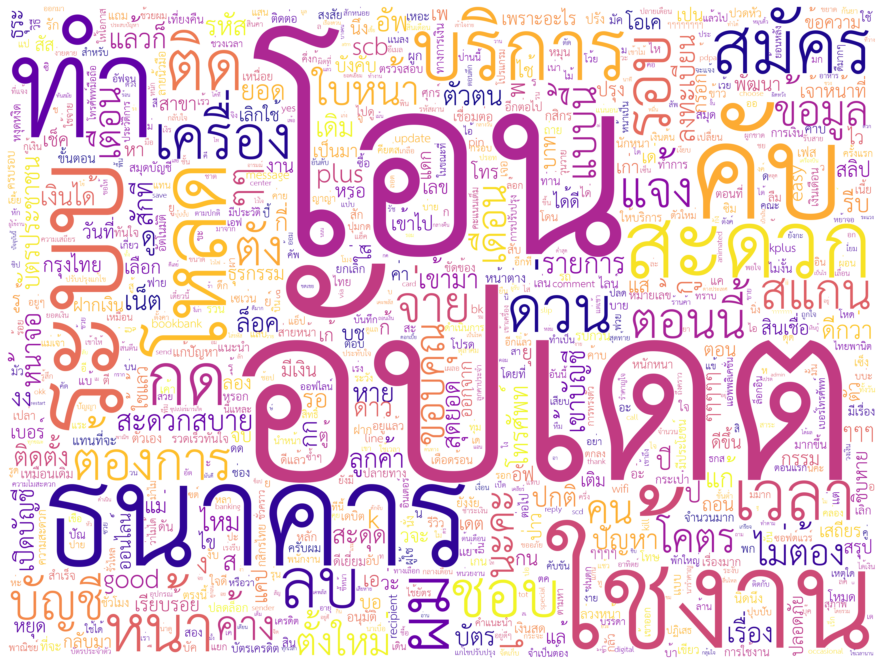

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()


Word cloud - negative comment

In [ ]:
query_neg = test_df.query("`class` == 'neg' and `predict_class` == 'neg'")


text = " ".join(i for i in test_df.clean_comments)
stop_words = ["ห่วย","ห่วยแตก","app","แอปพลิเคชัน","โอน",
              "อัปเดต","ระบบ","กก","จบ","ธนาคาร","ทำ","เงิน","สะดวก","ดี","ดีมาก","ใช้งาน","คับ"] + th_stop_words
regexp = r"[ก-๙a-zA-Z']+"
wordcloud = WordCloud(
                      font_path="/content/THSarabunNew.ttf", 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      #mask=mask,
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                      contour_width=3, 
                      contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2,
                      stopwords = stop_words
                      ).generate(text)

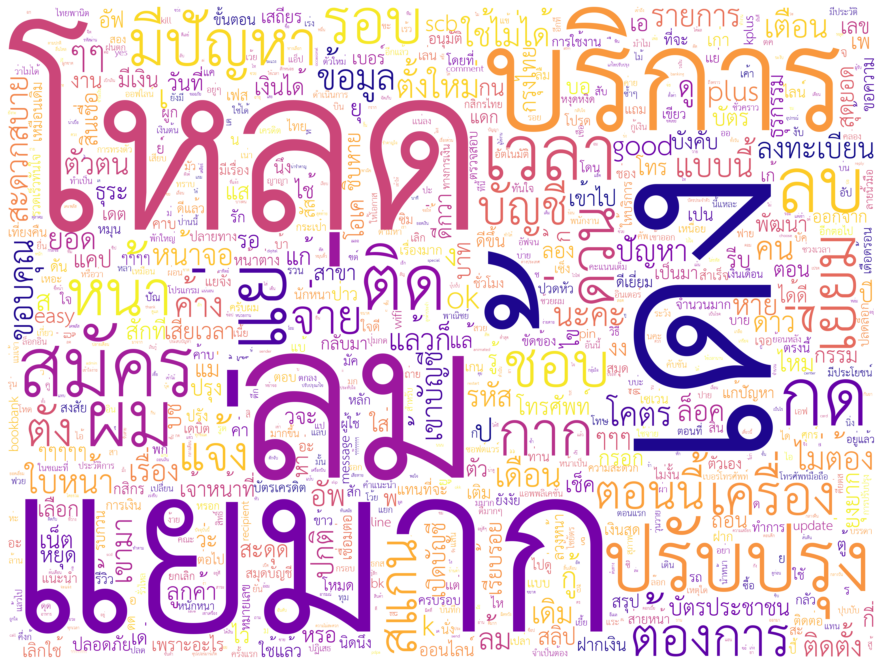

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

In [ ]:
print(wordcloud.words_.keys())

dict_keys(['เด้ง', 'แย่มาก', 'โหลด', 'ล่ม', 'บริการ', 'ปรับปรุง', 'แย่', 'สมัคร', 'กด', 'ผม', 'ติด', 'ลบ', 'เวลา', 'มีปัญหา', 'หน้า', 'ชอบ', 'ด่วน', 'กาก', 'รอบ', 'เยี่ยม', 'เครื่อง', 'ต้องการ', 'สแกน', 'ตอนนี้', 'บัญชี', 'จ่าย', 'ตัง', 'แจ้ง', 'ข้อมูล', 'ค้าง', 'ใบหน้า', 'แบบนี้', 'ขอบคุณ', 'เ', 'นะคะ', 'โคตร', 'คน', 'เดือน', 'ตั้งใหม่', 'ok', 'ใช้ไม่ได้', 'เตือน', 'ไม่ต้อง', 'ๆๆ', 'สะดวกสบาย', 'ง', 'รายการ', 'อัพ', 'ยอด', 'แล้วก็', 'ป', 'ปัญหา', 'ล้ม', 'เดิม', 'เรื่อง', 'กู้', 'ตัวตน', 'ดู', 'หน้าจอ', 'good', 'k', 'plus', 'หาย', 'ปกติ', 'ส', 'ติดตั้ง', 'ล็อค', 'ลงทะเบียน', 'เข้ามา', 'เข้าบัญชี', 'ดาว', 'รหัส', 'ลูกค้า', 'ไหม', 'แก้', 'เน็ต', 'สักที', 'ปี', 'กี่', 'งง', 'สะดุด', 'บัตรประชาชน', 'เงินได้', 'โทรศัพท์', 'พ', 'รีบ', 'รอ', 'บัตร', 'scb', 'เปิดบัญชี', 'เสียเวลา', 'สุดยอด', 'ยุ่งยาก', 'ดีกว่า', 'กรุงไทย', 'ธุระ', 'แม่', 'บช', 'แคป', 'โอเค', 'แส', 'กน', 'ก้', 'บาท', 'ยุ', 'เอ', 'สลิป', 'ไข', 'ๆๆๆ', 'รู้', 'หยุด', 'ว่ะ', 'กรอก', 'เลข', 'บอ', 'เรียบร้อย', 'อัฟ', 'ตัว', 'ถอน', 'เ

**CNN model with Gensim**

In [ ]:
predicted_classes_2 = np.argmax(predict_model2.predict([test_padded_doc, test_padded_doc, test_padded_doc]), axis=-1)

20/20 [==============================] - 0s 2ms/step


In [ ]:
predicted_classes_2

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,

In [ ]:
cate_predicted_classes_2 = mapClassLabel(predicted_classes_2)

In [ ]:
test_df = test_df.drop('predict_class', axis=1)
test_df.head()

content  score  thumbsUpCount  \
2748           สแกนใบหน้าไม่ดีระบบควรปรับปรุง    1.0            0.0   
2694                          ใช้งานสะดวกสบาย    5.0            0.0   
1931  แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​    1.0            0.0   
1575               ปิดปรับปรุงบ่อยมากคะแข้ไขั    3.0            0.0   
1934                               โหลดไม่ได้    5.0            0.0   

     reviewCreatedVersion            timestamp class  \
2748               11.9.1  2022-11-04 06:45:23   neg   
2694               11.9.1  2022-11-06 17:08:55   pos   
1931                0.0.0  2022-10-22 13:27:32   neg   
1575                0.0.0  2022-11-09 10:37:38   neg   
1934               3.59.0  2022-10-22 10:12:28   neg   

                        clean_comments  
2748      สแกน ใบหน้า ดี ระบบ ปรับปรุง  
2694                  ใช้งาน สะดวกสบาย  
1931  แย่มาก ​   ปรับปรุง ให้ ​ ค่าย ​  
1575                 ปรับปรุง แข้ ไข ั  
1934                              โหลด

In [ ]:
test_df["predict_class"] = np.array(cate_predicted_classes_2)

test_df.head()

content  score  thumbsUpCount  \
2748           สแกนใบหน้าไม่ดีระบบควรปรับปรุง    1.0            0.0   
2694                          ใช้งานสะดวกสบาย    5.0            0.0   
1931  แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​    1.0            0.0   
1575               ปิดปรับปรุงบ่อยมากคะแข้ไขั    3.0            0.0   
1934                               โหลดไม่ได้    5.0            0.0   

     reviewCreatedVersion            timestamp class  \
2748               11.9.1  2022-11-04 06:45:23   neg   
2694               11.9.1  2022-11-06 17:08:55   pos   
1931                0.0.0  2022-10-22 13:27:32   neg   
1575                0.0.0  2022-11-09 10:37:38   neg   
1934               3.59.0  2022-10-22 10:12:28   neg   

                        clean_comments predict_class  
2748      สแกน ใบหน้า ดี ระบบ ปรับปรุง           pos  
2694                  ใช้งาน สะดวกสบาย           pos  
1931  แย่มาก ​   ปรับปรุง ให้ ​ ค่าย ​           neg  
1575                 ปรับปรุง แข้ ไข ั           neg  
1934                              โหลด           pos

In [ ]:
y_true_2 = np.argmax(test_output_one_hot,axis = 1)
print(test_output_one_hot[0])
print(y_true_2[0])

[1. 0.]
0


In [ ]:
cm_cnn_gensim = confusion_matrix(y_true_2, predicted_classes_2)
np.savetxt("confusion_matrix_CNN_gensim.csv", cm_cnn_gensim, delimiter=",")

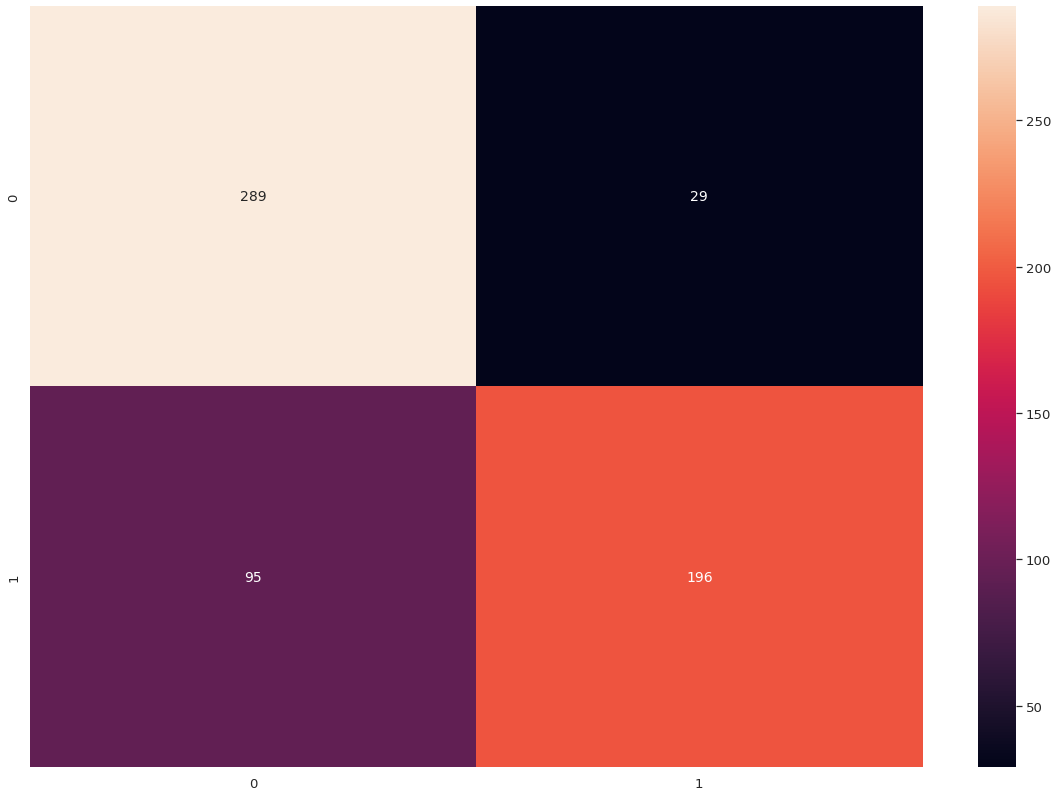

In [ ]:
test_df_cm_cnn_gensim = pd.DataFrame(cm_cnn_gensim, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(test_df_cm_cnn_gensim, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
print(classification_report(y_true_2, predicted_classes_2, target_names=label_test, digits=4))

              precision    recall  f1-score   support

         neg     0.7526    0.9088    0.8234       318
         pos     0.8711    0.6735    0.7597       291

    accuracy                         0.7964       609
   macro avg     0.8119    0.7912    0.7915       609
weighted avg     0.8092    0.7964    0.7929       609



Predict label compare with actual comment score

In [ ]:
len(test_df)

609

In [ ]:
query = test_df.query("`score` >= 3 and `predict_class` == 'pos'")

len(query)

203

In [ ]:
query.sample(20)

content  score  thumbsUpCount reviewCreatedVersion  \
1212      ใช้งานง่ายสะดวกสบาย    5.0            0.0               5.16.1   
1522   ดีมากๆๆ.เลยค่ะ.รักสุดๆ    5.0            0.0               3.56.0   
1650                       ดี    5.0            1.0               3.60.0   
1729                 บริการดี    5.0            0.0               3.60.0   
3481                    ดีมาก    5.0            0.0                0.0.0   
1847   ไทยพาณิชย์ดีมากเลยครับ    5.0            0.0                0.0.0   
1164                       ดี    5.0            0.0                0.0.0   
2077                    ดีมาก    5.0            0.0               3.59.0   
827                  ใช้ดีมาก    5.0            0.0               5.16.1   
1462                       ดี    5.0            1.0               5.16.1   
1855                 ดีมากเลย    5.0            0.0               3.59.0   
407                  ดีเยี่ยม    5.0            0.0               5.16.1   
2552  ให้บริการดีขอบคุณมากค่ะ    5.0            0.0               11.9.1   
3256                       ดี    5.0            0.0               10.9.1   
635                    ดีครับ    5.0            0.0               5.15.4   
596                        ดี    5.0            0.0               5.15.0   
967                        ดี    5.0            0.0               5.16.1   
1700                    ดีมาก    5.0            0.0               3.60.0   
174   ใช่ง่ายสะดวก OK. เลยชอบ    5.0            0.0               5.16.3   
318                 ดีมากครับ    5.0            0.0              5.15.10   

                timestamp class       clean_comments predict_class  
1212  2022-10-18 12:02:32   pos     ใช้งาน สะดวกสบาย           pos  
1522  2022-11-12 00:46:13   pos         ดีมาก ๆๆ รัก           pos  
1650  2022-11-04 09:08:01   pos                   ดี           pos  
1729  2022-11-01 00:58:09   pos            บริการ ดี           pos  
3481  2022-10-13 00:27:18   pos                ดีมาก           pos  
1847  2022-10-26 14:38:40   pos    ไทย พาณิชย์ ดีมาก           pos  
1164  2022-10-19 05:39:42   pos                   ดี           pos  
2077  2022-10-16 11:20:48   pos                ดีมาก           pos  
827   2022-10-27 11:26:56   pos                ดีมาก           pos  
1462  2022-10-13 14:37:35   pos                   ดี           pos  
1855  2022-10-26 09:06:16   pos                ดีมาก           pos  
407   2022-11-05 08:10:48   pos             ดีเยี่ยม           pos  
2552  2022-11-12 06:50:52   pos  ให้บริการ ดี ขอบคุณ           pos  
3256  2022-10-20 11:44:32   pos                   ดี           pos  
635   2022-10-31 23:18:35   pos                   ดี           pos  
596   2022-11-01 14:11:21   pos                   ดี           pos  
967   2022-10-23 22:36:15   pos                   ดี           pos  
1700  2022-11-01 15:54:22   pos                ดีมาก           pos  
174   2022-11-09 07:01:18   pos     สะดวก   ok   ชอบ           pos  
318   2022-11-06 10:34:06   pos                ดีมาก           pos

In [ ]:
query = test_df.query("`score` < 3 and `predict_class` == 'neg'")

len(query)

223

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
1667                                  ทำไมเข้าแอฟไม่ได้    1.0            0.0   
133                      แย่มาก แก้ไขด่วน ต้องการทำธุระ    1.0            0.0   
3485  ทำไมสมัคแอปไม่ได้เลยคะทำหลายรอบมากก็ไม่ได้ ใคร...    1.0            0.0   
2381  ตอนนี้ก็ใช้งานไม่ได้ 5-10-65/11.30น. ถ้าชดเชยค...    1.0            0.0   
1021  แอฟรวนมากค่ะ..เข้าใช้งานไม่ได้..แก้ไขด้วยค่ะ.....    1.0            0.0   
3062  ไม่ค่อยดีช้า แถมเวลาระบบมีปัญหาไม่ค่อยแจ้งเตือ...    2.0            8.0   
2735                        เข้ากระเป๋า พร้อมเพย์ไม่ได้    2.0            1.0   
2445                                         ล่มบ่อยมาก    1.0            0.0   
2214  ธนาคารอื่นๆใม่มีปัญหา เรื่องความติดตั้งแอปเวลา...    1.0            4.0   
1272  แอปบังคับให้ปิด เปิดเครื่องใหม่แต่ทำแล้วก็เข้า...    1.0            1.0   
2994  ทำมั้ยตอนนี้เติมช็อปปี้เพไม่ได้คะ ที่ผ่านเต็มไ...    1.0            0.0   
2248  ขอแก้แอปหน่อยก้อดีนะ เข้าได้แต่ไม่แสดงเลยว่า ม...    2.0            3.0   
2321  โปรดแจ้งเตือนด้วยคับถ้ามีการอัปเดทอะไรคับ เดือ...    2.0            1.0   
2753                     แย่ แสกนใบหน้าไม่ผ่าน สมัครยาก    1.0            0.0   
672   แย่มากๆคับอยู่แอพก็เด่งเข้าเองโดยที่ไม่ได้ทำไร...    1.0            0.0   
343     ดีมากแต่ว่าตอนนี้ทำไมถึงเข้าแอปไม่ได้ไม่รุ้ครับ    1.0            0.0   
809   จะให้เปิดปิดเครื่องอีกนานมั้ยคะ แก้ไม่ได้เลยต้...    1.0            7.0   
3243   app ห่วยแตกมาก แล้วบังคับให้ใช้ จะโอนก็โอนไม่ได้    1.0            1.0   
3398  แสกนหน้าไม่ผ่านเลย. ต้องทำยังไง มีแต่ต้องไปธนา...    1.0            0.0   
235   เมื่อไรจะแก้ปัญหา (146)เข้าแอปไม่ได้ครับ Kill ...    1.0            1.0   

     reviewCreatedVersion            timestamp class  \
1667               3.60.0  2022-11-03 06:17:02   neg   
133                5.16.1  2022-11-10 00:25:10   neg   
3485               11.9.1  2022-10-12 22:11:14   neg   
2381               3.59.0  2022-10-05 04:44:33   neg   
1021               5.16.1  2022-10-22 08:54:26   neg   
3062               11.9.1  2022-10-25 08:24:54   neg   
2735                0.0.0  2022-11-04 19:49:29   neg   
2445               3.59.0  2022-10-03 05:31:24   neg   
2214               3.59.0  2022-10-10 03:00:28   neg   
1272               5.16.1  2022-10-17 14:33:17   neg   
2994               11.9.1  2022-10-26 03:54:50   neg   
2248               3.59.0  2022-10-08 20:39:04   neg   
2321               3.59.0  2022-10-07 17:38:23   neg   
2753               11.9.1  2022-11-04 01:35:32   neg   
672                 0.0.0  2022-10-31 05:00:03   neg   
343                5.16.2  2022-11-06 03:47:01   neg   
809                5.16.1  2022-10-28 02:19:05   neg   
3243               11.9.1  2022-10-20 11:54:22   neg   
3398               11.9.1  2022-10-16 11:27:42   neg   
235                5.16.1  2022-11-08 01:30:10   neg   

                                         clean_comments predict_class  
1667                                        แอปพลิเคชัน           neg  
133                     แย่มาก   ด่วน   ต้องการ ทำ ธุระ           neg  
3485                ส มัค แอปพลิเคชัน ทำ รอบ   รู้ นะคะ           neg  
2381  ตอนนี้ ใช้งาน   51065 / 1130 น   ชดเชย 100   ป...           neg  
1021  แอปพลิเคชัน รวน ใช้งาน ดีกว่า นะคะ อัปเดต แอปพ...           neg  
3062  ดี   แถม เวลา ระบบ มีปัญหา แจ้ง เตือน คน รีบ โ...           neg  
2735                                    กระเป๋า   เพ ย์           neg  
2445                                                ล่ม           neg  
2214  ธนาคาร ใม่ มีปัญหา   เรื่อง ติดตั้ง แอปพลิเคชั...           neg  
1272  แอปพลิเคชัน บังคับ   เครื่อง ทำ แล้วก็   ลบ ติ...           neg  
2994  ทำ ตอนนี้ เติม ช็อป ปี้ เพ   เต็ม   เ เก้ ไข ด...           neg  
2248  แก้ แอปพลิเคชัน ก็ ดี     ตัง เข้าออก   รายการ...           neg  
2321         โปรด แจ้ง เตือน คับ อัปเดต คับ   เดือดร้อน           neg  
2753                         แย่   แส กน ใบหน้า   สมัคร           neg  
672   แย่มาก คับ แอปพลิเคชัน เด่ ง โดยที่ ทำ ลบ โหลด...           neg  
343              

In [ ]:
query = test_df.query("`score` >= 3 and `predict_class` != 'pos'")

len(query)

161

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
662                  แอฟแย่มากๆช่วงสงสัยไม่มีใครจ่ยเงิน    3.0            0.0   
3389                                         ใช้งานสบาย    5.0            0.0   
1493  ใช้งานดีapp k plus สะดวกสบายใครยังไม่ลองใช้ลอง...    5.0            0.0   
322   เปลี่ยนโทรศัพท์ใหม่แล้วเข้าแอปไม่ได้เป็นเพราะอ...    5.0            0.0   
2071                                          very good    5.0            0.0   
2012                       ไม่มีปัญหาอะไรนะ บ่นกันไปเอง    5.0            0.0   
205   ทำไมแอบไม่เปิดบริการแล้วทำไมต้องให้ลบแอบออกและ...    3.0            3.0   
2298                     ตั้งแต่มีSCB EASY สะดวกมากขึ้น    5.0            0.0   
2439          ดีไม่ต้องไปธนาคารฝากถอนโอนจ่ายในแอ็ปเดียว    5.0            0.0   
2528                                          โอนไม่ได้    4.0            0.0   
3086                                          เยี่ยมมาก    5.0            0.0   
1102                       ดีมากคับคิดดีแล้วที่เลือกใช้    5.0            0.0   
771   ปัจจุบันนี้ เวลาลบออกแล้วติดตั้งใหม่ ใช้เวลานา...    5.0            0.0   
1442                                             Ok Yes    5.0            0.0   
2475                                 ผ่านครับจัดว่าเด่ด    5.0            0.0   
2930  เราประสบปัญหาทางด้านการเงิน จะกู้ก็ไม่มีสลิปเง...    5.0            0.0   
939   ปัญหาคือเวลาเปลี่ยนเครื่องใหม่ แม่งต้องใช้เน็ต...    3.0            6.0   
3148    โอนเงินเข้าบัญชีไม่ได้แย่อยู่ค่ะ โอนหลายรอบแล้ว    4.0            0.0   
3492  ครบรอบ33 ปี ลูกค้ากรุงไทย ครับครบรอบขอบคุณ กรุ...    5.0            3.0   
1290                                    สมัครไม่ได้ครับ    3.0            1.0   

     reviewCreatedVersion            timestamp class  \
662                 0.0.0  2022-10-31 07:59:43   neg   
3389                0.0.0  2022-10-16 17:48:15   pos   
1493               5.16.1  2022-10-13 00:52:37   pos   
322                5.16.2  2022-11-06 08:18:42   neg   
2071               3.59.0  2022-10-16 15:52:42   pos   
2012               3.59.0  2022-10-18 15:43:11   pos   
205                5.16.1  2022-11-08 14:36:16   neg   
2298               3.59.0  2022-10-07 23:49:18   pos   
2439               3.59.0  2022-10-03 10:30:25   pos   
2528                0.0.0  2022-09-30 11:43:14   neg   
3086               11.9.1  2022-10-25 07:53:54   pos   
1102               5.16.1  2022-10-20 13:54:49   pos   
771                5.15.5  2022-10-29 00:03:38   neg   
1442               5.16.0  2022-10-14 03:30:22   pos   
2475               3.59.0  2022-10-02 08:35:22   pos   
2930               10.8.1  2022-10-27 23:05:27   neg   
939                5.16.1  2022-10-24 15:10:15   neg   
3148               11.6.3  2022-10-24 08:01:22   neg   
3492               11.9.1  2022-10-12 10:21:25   pos   
1290               5.16.1  2022-10-17 08:48:16   neg   

                                         clean_comments predict_class  
662                   แอปพลิเคชัน แย่มาก สงสัย จ่ย เงิน           neg  
3389                                             ใช้งาน           neg  
1493  ใช้งาน ดี app   k plus   สะดวกสบาย ลอง ลอง ดู ...           neg  
322                    โทรศัพท์ แอปพลิเคชัน เพราะอะไร ?           neg  
2071                                               good           neg  
2012                                      มีปัญหา   บ่น           neg  
205   แอปพลิเคชัน บริการ ลบ แอปพลิเคชัน ติด ตั้งใหม่...           neg  
2298                         scb   easy   สะดวก มากขึ้น           neg  
2439            ดี ไม่ต้อง ธนาคาร ฝาก ถอน โอน จ่าย แอ็ป           neg  
2528                                                โอน           neg  
3086                                             เยี่ยม           neg  
1102                             ดีมาก คับ ดีแล้ว เลือก           neg  
771     ปัจจุบันนี้   เวลา ลบ ติด ตั้งใหม่   ใช้เวลานาน           neg  
1442                                           ok   yes           neg  
2475                                              เด่ ด           neg  
2930  ประสบปัญหา 

In [ ]:
query = test_df.query("`score` < 3 and `predict_class` != 'neg'")

len(query)

22

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
680   เข้าระบบได้ช้ามากๆๆๆ ระบบแอพแย่มาก จนคิดอยากเป...    2.0            0.0   
2531                             ปิดถึงกี่​โมง​ครับท่าน    2.0            0.0   
437                                          เข้ายากมาก    1.0            0.0   
2373  ยิ่งใช้ ยิ่งเร่า ล้มได้ ล้มดี ล้มแม่งทุกวัน นี...    2.0            0.0   
2505                                 ระบบล่มบ่อยยังครับ    1.0            0.0   
1909                              ฉันอัปเดตไม่ได้ช้วยที    1.0            0.0   
492                                            ใช้ไม่ดี    1.0            0.0   
1970                 ทำไมถึงปิดปรับปรุงระบบบ่อยมากเลยคะ    2.0            0.0   
3397  ถ้าจะทำออกมาแล้วบัคระบบเยอะ หรือ ทำให้ยุ่งยากแ...    1.0            2.0   
128      ระบบเข้าไม่ได้ อัปเดตแล้วเข้าไม่ได้บ้างช้าบ้าง    1.0            0.0   
3092  เวลาจะเข้าระบบนานมากกว่าจะเข้าระบบได้อยากให้พั...    2.0            2.0   
2748                     สแกนใบหน้าไม่ดีระบบควรปรับปรุง    1.0            0.0   
3267                            แอปเป็นไรทำไมเข้าไม่ได้    1.0            0.0   
1926                                     มีปัญญาบ่อยชิป    1.0            0.0   
2486                               จะเลิกใช้ละปัญหาเยอะ    1.0            0.0   
728                                               ดีค่ะ    1.0            0.0   
756                                 ช้ามากกว่าจะเข้าได้    1.0            0.0   
1083                    โหลดเคะพลัสอะไรไม่ได้เลยห่วยมาก    1.0            0.0   
1353                      ระบบไม่ค่อยเสถียรเลยช่วงหลังๆ    2.0            0.0   
1199                                         ระบบแย่มาก    1.0            0.0   

     reviewCreatedVersion            timestamp class  \
680               5.15.10  2022-10-31 01:40:24   neg   
2531               3.56.0  2022-09-30 10:37:42   neg   
437                5.16.2  2022-11-05 02:11:36   neg   
2373               3.59.0  2022-10-05 08:40:31   neg   
2505               3.59.0  2022-10-01 10:59:39   neg   
1909               3.54.0  2022-10-23 10:24:00   neg   
492                 0.0.0  2022-11-04 09:18:04   neg   
1970               3.60.0  2022-10-20 16:58:23   neg   
3397               11.9.1  2022-10-16 12:31:49   neg   
128                 0.0.0  2022-11-10 01:39:23   neg   
3092               11.9.1  2022-10-25 07:48:51   neg   
2748               11.9.1  2022-11-04 06:45:23   neg   
3267               11.9.1  2022-10-20 11:33:00   neg   
1926               3.60.0  2022-10-22 18:03:06   neg   
2486               3.59.0  2022-10-02 04:00:44   neg   
728                5.16.1  2022-10-30 01:08:57   pos   
756                 0.0.0  2022-10-29 09:05:16   neg   
1083                0.0.0  2022-10-21 02:49:10   neg   
1353               5.16.1  2022-10-16 07:01:35   neg   
1199               5.16.1  2022-10-18 14:02:22   neg   

                                         clean_comments predict_class  
680   ระบบ ๆๆๆ   ระบบ แอปพลิเคชัน แย่มาก   ธนาคาร   ...           pos  
2531                                   กี่ ​ โมง ​ ท่าน           pos  
437                                                               pos  
2373    เร่า   ล้ม   ล้ม ดี   ล้ม แม่ ง   สิ้นเดือน ...           pos  
2505                                           ระบบ ล่ม           pos  
1909                                        อัปเดต ช้วย           pos  
492                                                  ดี           pos  
1970                                      ปรับปรุง ระบบ           pos  
3397  ทำ ออกมา บัค ระบบ     ยุ่งยาก สุดท้าย ธนาคาร เ...           pos  
128                                       ระบบ   อัปเดต           pos  
3092  เวลา ระบบ ระบบ พัฒนา ปรับปรุงแก้ไข ระบบ ล่ม   ...           pos  
2748                       สแกน ใบหน้า ดี ระบบ ปรับปรุง           pos  
3267                                 แอปพลิเคชัน เป็นไร           pos  
1926                                          ปัญญา ชิป           pos  
2486                                      เลิกใช้ ปัญหา           pos  
728              

Predict label compare with actual label

In [ ]:
query = test_df.query("`class` == 'pos' and `predict_class` == 'pos'")

len(query)

196

In [ ]:
query.sample(20)

content  score  thumbsUpCount reviewCreatedVersion  \
1942      ใช้งานดีมากครับ    5.0            0.0                0.0.0   
1898           ขอบคุณครับ    5.0            0.0               3.60.0   
1875            ดีมากครับ    5.0            0.0               3.60.0   
1212  ใช้งานง่ายสะดวกสบาย    5.0            0.0               5.16.1   
407              ดีเยี่ยม    5.0            0.0               5.16.1   
1862           ดีมากฯครับ    5.0            0.0               3.60.0   
3382             ดีมากคับ    4.0            0.0               11.9.1   
93                    ดีๆ    5.0            0.0               5.16.3   
3003         ดีมากครับ🕸️☺    5.0            0.0              10.13.1   
1216  บริการดีมากประทับใจ    5.0            0.0               5.16.1   
827              ใช้ดีมาก    5.0            0.0               5.16.1   
1606             ดีมากค่ะ    5.0            0.0                0.0.0   
1437               ดีครับ    5.0            0.0               5.16.1   
3161                   ดี    5.0            0.0               11.9.1   
2805         ดีมากเลยครับ    5.0            0.0               11.9.1   
2031                  ได้    5.0            0.0                0.0.0   
1710      สะดวกและปลอดภัย    5.0            0.0               3.60.0   
1868            ดี มากค่ะ    5.0            0.0                0.0.0   
167                    ดี    5.0            0.0               5.16.1   
2002       ใช้งานดีมากค่ะ    5.0            0.0               3.54.0   

                timestamp class         clean_comments predict_class  
1942  2022-10-22 03:49:13   pos           ใช้งาน ดีมาก           pos  
1898  2022-10-24 02:52:30   pos                 ขอบคุณ           pos  
1875  2022-10-25 08:10:50   pos                  ดีมาก           pos  
1212  2022-10-18 12:02:32   pos       ใช้งาน สะดวกสบาย           pos  
407   2022-11-05 08:10:48   pos               ดีเยี่ยม           pos  
1862  2022-10-25 20:32:46   pos                  ดีมาก           pos  
3382  2022-10-17 04:46:20   pos              ดีมาก คับ           pos  
93    2022-11-10 14:18:54   pos                     ดี           pos  
3003  2022-10-26 00:42:22   pos              ดีมาก 🕸️☺           pos  
1216  2022-10-18 11:26:29   pos  บริการ ดีมาก ประทับใจ           pos  
827   2022-10-27 11:26:56   pos                  ดีมาก           pos  
1606  2022-11-06 16:42:53   pos                  ดีมาก           pos  
1437  2022-10-14 04:59:13   pos                     ดี           pos  
3161  2022-10-23 16:25:36   pos                     ดี           pos  
2805  2022-11-01 19:42:53   pos                  ดีมาก           pos  
2031  2022-10-18 02:01:01   pos                                  pos  
1710  2022-11-01 13:42:09   pos          สะดวก ปลอดภัย           pos  
1868  2022-10-25 14:07:45   pos                   ดี             pos  
167   2022-11-09 09:10:40   pos                     ดี           pos  
2002  2022-10-19 05:19:45   pos           ใช้งาน ดีมาก           pos

In [ ]:
query = test_df.query("`class` == 'neg' and `predict_class` == 'neg'")

len(query)

289

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
3358  เพราะอะไรบันชีต้นทางโอนเงินมาตรวจสอบ สรีปเรียบ...    1.0            0.0   
2637                                  เสียการทรงตัวบ่อย    3.0            0.0   
343     ดีมากแต่ว่าตอนนี้ทำไมถึงเข้าแอปไม่ได้ไม่รุ้ครับ    1.0            0.0   
2383  วันนี้ 5/10/65 แอพเป็นอะไรค่ะ ไม่สามารถให้บริก...    5.0          353.0   
126   ระบบเด่วนี้แย่มากๆมากบางทีก็อัปเดตแล้วก็เข้าใช...    1.0            0.0   
179   แอปเปิดขึ้นมาเอง ทั้งที่ไม่ได้กดไม่ได้โดนเลย เ...    3.0            0.0   
373   App เข้าไม่ได้ปิดเปิดเครื่องใหม่ก็ไม่ได้ ลบติด...    1.0            4.0   
2285                      ทำไมต้องปรับปรุงบ่อยๆๆด้วยค่ะ    5.0            0.0   
1950                               ทำไมเข้าใช้งานไม่ได้    1.0            0.0   
623                          ติดตั้งไม่ได้แต่แอปอื่นได้    1.0            0.0   
330   เปลี่ยนเครื่องใหม่แต่เข้าไม่ได้ ลบแล้วตั้งใหม่...    1.0            0.0   
395                       ทำไมเข้า app ไม่ได้ 2 วันแล้ว    5.0            0.0   
2449  มีปัญหาบ่อยเรื่องโอนเงินถอนเงินเมื่อกี่จะโอนเง...    1.0            0.0   
2400  เข้าแอฟก็ช้าแล้วยังมีมาบอกว่าแอบระบบผิดหลาดไม่...    1.0            8.0   
1384                            หมุนอยู่นั่นอัพก็ไม่อัพ    2.0            0.0   
3342                              ไม่มีปุ่มกดลืมรหัสPIN    3.0            0.0   
2393  แย่มาก แอฟธนาคารเข้าไม่ได้ โครตห่วย แล้วรีบจะต...    1.0            1.0   
3280                                            ห่วยแตก    1.0            0.0   
2522                           โอนเงินออกจากบัญชีไม่ได้    1.0            0.0   
1059          เป็นอะไรครับวันนี้เข้าใช้งานไม่ได้เลยครับ    1.0            0.0   

     reviewCreatedVersion            timestamp class  \
3358                0.0.0  2022-10-18 00:57:00   neg   
2637               11.9.1  2022-11-09 10:38:44   neg   
343                5.16.2  2022-11-06 03:47:01   neg   
2383               3.59.0  2022-10-05 04:40:20   neg   
126                5.16.3  2022-11-10 02:57:19   neg   
179                5.16.1  2022-11-09 05:23:57   neg   
373                5.16.2  2022-11-05 15:09:15   neg   
2285               3.53.0  2022-10-08 02:33:32   neg   
1950               3.44.0  2022-10-21 13:41:53   neg   
623                5.16.1  2022-11-01 05:28:52   neg   
330                5.16.1  2022-11-06 06:52:39   neg   
395                5.16.2  2022-11-05 10:34:44   neg   
2449               3.59.0  2022-10-03 05:05:22   neg   
2400               3.59.0  2022-10-05 03:39:02   neg   
1384               5.16.0  2022-10-15 09:42:08   neg   
3342               11.9.1  2022-10-18 08:22:31   neg   
2393               3.59.0  2022-10-05 04:05:30   neg   
3280                0.0.0  2022-10-20 11:19:11   neg   
2522                0.0.0  2022-09-30 15:08:32   neg   
1059               5.16.1  2022-10-21 10:59:20   neg   

                                         clean_comments predict_class  
3358  เพราะอะไร บัญชี ต้นทาง โอน เงิน ตรวจสอบ   ส รี...           neg  
2637                                          การทรงตัว           neg  
343                        ดีมาก ตอนนี้ แอปพลิเคชัน รุ้           neg  
2383    5 / 10 / 65   แอปพลิเคชัน   ให้บริการ ชั่วคร...           neg  
126   ระบบ เด่ ว แย่มาก อัปเดต แล้วก็ ใช้งาน ลบ แอปพ...           neg  
179                       แอปพลิเคชัน   กด โดน   เป็นมา           neg  
373   app   เครื่อง   ลบ ติด ตั้งใหม่   app   เด้ง  ...           neg  
2285                                           ปรับปรุง           neg  
1950                                             ใช้งาน           neg  
623                                 ติดตั้ง แอปพลิเคชัน           neg  
330                       เครื่อง   ลบ ตั้งใหม่ เข้าไม้           neg  
395                                         app     2             neg  
2449  มีปัญหา เรื่อง โอน เงิน ถอนเงิน กี่ โอน เงิน ม...           neg  
2400  แอปพลิเคชัน ยังมี บอ แอปพลิเคชัน ระบบ หลา ด สา...           neg  
1384                                  หมุน อยู่ อัพ อัพ           neg  
3342             

In [ ]:
query = test_df.query("`class` == 'pos' and `predict_class` != 'pos'")

len(query)

95

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
955                                ทำรายการเร้วทันใจดีะ    5.0            0.0   
1773  เป็น app ที่ใช้งานง่ายสะดวกสบายไม่ต้องไปโอนที่...    5.0            1.0   
2404                                               Good    5.0            0.0   
2920                                    ชอบมากที่สุดคับ    5.0            0.0   
782                       แต่ผมว่า บริการเค้า ok นะครับ    4.0            0.0   
1102                       ดีมากคับคิดดีแล้วที่เลือกใช้    5.0            0.0   
3301  ดีครับ.แต่ตอนนี้โหลดแอปเข้ามาแต่ติดทขั้นตอนที่...    3.0            6.0   
1879                                             ชอบมาก    5.0            0.0   
913                                               ก็OKk    5.0            0.0   
370                                           เยี่ยมมาก    5.0            0.0   
2439          ดีไม่ต้องไปธนาคารฝากถอนโอนจ่ายในแอ็ปเดียว    5.0            0.0   
3086                                          เยี่ยมมาก    5.0            0.0   
2205                                            ดีคับผม    5.0            0.0   
1442                                             Ok Yes    5.0            0.0   
1372                                               โอเค    4.0            0.0   
921                                               💚💚💚💚💚    5.0            0.0   
825                                      พึ่งได้ทุกเวลา    5.0            0.0   
49    ถ้าบัญชีอยู่อีกเครื่องเราต้องการเข้าเครื่องใหม...    4.0            0.0   
1977                               สะดวกในเรื่องการเงิน    5.0            0.0   
2641                               ใช้งานคล่องไม่สดุดok    5.0            0.0   

     reviewCreatedVersion            timestamp class  \
955                 0.0.0  2022-10-24 05:27:59   pos   
1773               3.60.0  2022-10-30 12:11:37   pos   
2404               3.59.0  2022-10-05 00:27:08   pos   
2920               11.9.1  2022-10-28 12:53:30   pos   
782               5.15.10  2022-10-28 14:54:56   pos   
1102               5.16.1  2022-10-20 13:54:49   pos   
3301               11.9.1  2022-10-20 05:27:15   pos   
1879                0.0.0  2022-10-25 03:09:05   pos   
913                5.16.1  2022-10-25 09:18:36   pos   
370                5.16.2  2022-11-05 16:24:47   pos   
2439               3.59.0  2022-10-03 10:30:25   pos   
3086               11.9.1  2022-10-25 07:53:54   pos   
2205               3.59.0  2022-10-10 07:01:46   pos   
1442               5.16.0  2022-10-14 03:30:22   pos   
1372               5.16.0  2022-10-15 15:13:52   pos   
921                 0.0.0  2022-10-25 04:44:35   pos   
825                5.16.1  2022-10-27 13:10:51   pos   
49                  0.0.0  2022-11-11 12:50:04   pos   
1977               3.60.0  2022-10-20 08:52:44   pos   
2641               11.9.1  2022-11-09 09:05:31   pos   

                                         clean_comments predict_class  
955                               ทำ รายการ เร้ว ใจดี ะ           neg  
1773          app   ใช้งาน สะดวกสบาย ไม่ต้อง โอน ธนาคาร           neg  
2404                                               good           neg  
2920                                            ชอบ คับ           neg  
782                             ผม   บริการ เค้า   ok             neg  
1102                             ดีมาก คับ ดีแล้ว เลือก           neg  
3301  ดี ตอนนี้ โหลด แอปพลิเคชัน เข้ามา ติด ท ตอนที่...           neg  
1879                                                ชอบ           neg  
913                                                 okk           neg  
370                                              เยี่ยม           neg  
2439            ดี ไม่ต้อง ธนาคาร ฝาก ถอน โอน จ่าย แอ็ป           neg  
3086                                             เยี่ยม           neg  
2205                                          ดี คับ ผม           neg  
1442                                           ok   yes           neg  
1372                                               โอเค           neg  
921              

In [ ]:
query = test_df.query("`class` == 'neg' and `predict_class` != 'neg'")

len(query)

29

In [ ]:
query.sample(20)

content  score  thumbsUpCount  \
2104                               เวลาupdateทำไมช้ามาก    3.0            0.0   
288                              เงินในระบบธนาคารช้ามาก    5.0            0.0   
3233                           ระบบแย่มากอัปเดทระบบตลอด    5.0            0.0   
437                                          เข้ายากมาก    1.0            0.0   
2519  ในการขอสินเชื่อ..เป็นลูกค้าประจำอยู่แล้ว น่าจะ...    3.0            0.0   
2373  ยิ่งใช้ ยิ่งเร่า ล้มได้ ล้มดี ล้มแม่งทุกวัน นี...    2.0            0.0   
1400                                หลังๆมานี้ช้ามากค่ะ    5.0            0.0   
756                                 ช้ามากกว่าจะเข้าได้    1.0            0.0   
1926                                     มีปัญญาบ่อยชิป    1.0            0.0   
2748                     สแกนใบหน้าไม่ดีระบบควรปรับปรุง    1.0            0.0   
2511                                      แต่โหลดไม่ได้    5.0            0.0   
1199                                         ระบบแย่มาก    1.0            0.0   
1934                                         โหลดไม่ได้    5.0            0.0   
3397  ถ้าจะทำออกมาแล้วบัคระบบเยอะ หรือ ทำให้ยุ่งยากแ...    1.0            2.0   
1970                 ทำไมถึงปิดปรับปรุงระบบบ่อยมากเลยคะ    2.0            0.0   
2531                             ปิดถึงกี่​โมง​ครับท่าน    2.0            0.0   
3092  เวลาจะเข้าระบบนานมากกว่าจะเข้าระบบได้อยากให้พั...    2.0            2.0   
3267                            แอปเป็นไรทำไมเข้าไม่ได้    1.0            0.0   
492                                            ใช้ไม่ดี    1.0            0.0   
2152                            เข้าใช้โปรแกรมไม่ได้ค่ะ    5.0            0.0   

     reviewCreatedVersion            timestamp class  \
2104               3.54.0  2022-10-14 11:46:51   neg   
288                5.16.1  2022-11-06 23:30:48   neg   
3233               11.9.1  2022-10-20 12:02:25   neg   
437                5.16.2  2022-11-05 02:11:36   neg   
2519                0.0.0  2022-09-30 17:27:17   neg   
2373               3.59.0  2022-10-05 08:40:31   neg   
1400               5.16.0  2022-10-15 02:27:32   neg   
756                 0.0.0  2022-10-29 09:05:16   neg   
1926               3.60.0  2022-10-22 18:03:06   neg   
2748               11.9.1  2022-11-04 06:45:23   neg   
2511                0.0.0  2022-10-01 05:38:13   neg   
1199               5.16.1  2022-10-18 14:02:22   neg   
1934               3.59.0  2022-10-22 10:12:28   neg   
3397               11.9.1  2022-10-16 12:31:49   neg   
1970               3.60.0  2022-10-20 16:58:23   neg   
2531               3.56.0  2022-09-30 10:37:42   neg   
3092               11.9.1  2022-10-25 07:48:51   neg   
3267               11.9.1  2022-10-20 11:33:00   neg   
492                 0.0.0  2022-11-04 09:18:04   neg   
2152               3.52.0  2022-10-12 10:36:50   neg   

                                         clean_comments predict_class  
2104                                        เวลา update           pos  
288                                    เงิน ระบบ ธนาคาร           pos  
3233                            ระบบ แย่มาก อัปเดต ระบบ           pos  
437                                                               pos  
2519                สินเชื่อ ลูกค้าประจำ อยู่แล้ว   กู้           pos  
2373    เร่า   ล้ม   ล้ม ดี   ล้ม แม่ ง   สิ้นเดือน ...           pos  
1400                                                              pos  
756                                                               pos  
1926                                          ปัญญา ชิป           pos  
2748                       สแกน ใบหน้า ดี ระบบ ปรับปรุง           pos  
2511                                               โหลด           pos  
1199                                        ระบบ แย่มาก           pos  
1934                                               โหลด           pos  
3397  ทำ ออกมา บัค ระบบ     ยุ่งยาก สุดท้าย ธนาคาร เ...           pos  
1970                                      ปรับปรุง ระบบ           pos  
2531             

Word cloud - positive comment

In [ ]:
query_pos = test_df.query("`class` == 'pos' and `predict_class` == 'pos'")

from wordcloud import WordCloud
text = " ".join(i for i in test_df.clean_comments)
stop_words = ["ดีมาก", "ดี", "ห่วย","ห่วยแตก","โคตรห่วย","แย่มาก","แย่","แย่จัง","กาก","ล่ม","ระบบล่ม","ปรับปรุง",
              "แอพพลิเคชันล่ม","แอปพลิเคชันล่ม","แอปพลิเคชันมีปัญหา","แอปพลิเคชันแย่มาก","แอปพลิเคชันเด้ง","ยุ่งยาก",
              "ลบติดตั้งใหม่","ล้ม","ใช้ไม่ได้","มีปัญหา","เด้ง","เสียเวลา","อัปเดตห่วย","ดีคับ","ok",
              "เยี่ยม","ดีมากคับ","app","แอปพลิเคชัน"] + th_stop_words
regexp = r"[ก-๙a-zA-Z']+"
wordcloud = WordCloud(
                      font_path="/content/THSarabunNew.ttf", 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      #mask=mask,
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                      contour_width=3, 
                      contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2,
                      stopwords = stop_words
                      ).generate(text)

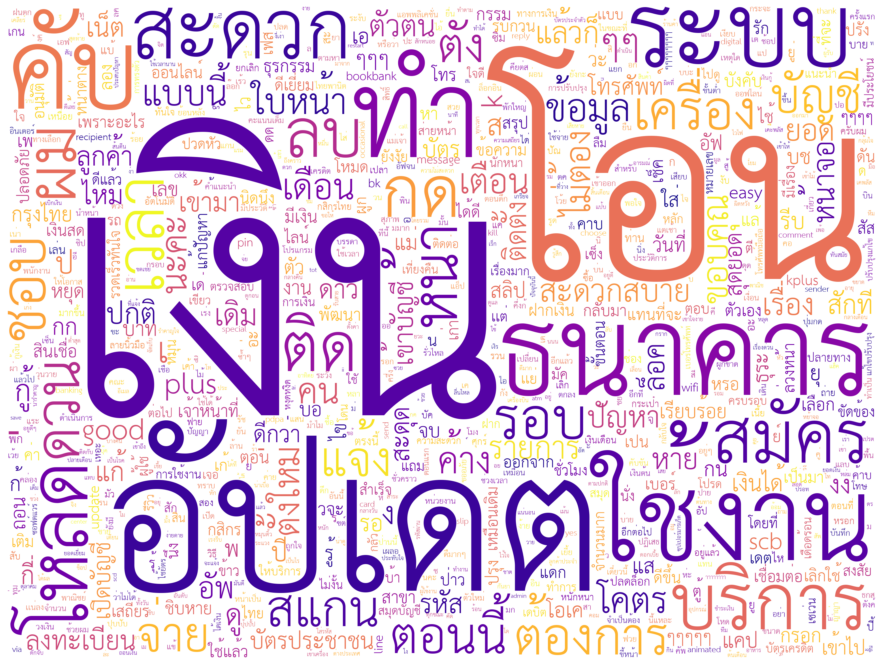

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

In [ ]:
print(wordcloud.words_.keys())

dict_keys(['เงิน', 'โอน', 'อัปเดต', 'ธนาคาร', 'ทำ', 'ใช้งาน', 'คับ', 'ระบบ', 'สะดวก', 'โหลด', 'บริการ', 'สมัคร', 'กด', 'ผม', 'ติด', 'ลบ', 'เวลา', 'หน้า', 'ชอบ', 'ด่วน', 'รอบ', 'เครื่อง', 'ต้องการ', 'สแกน', 'ตอนนี้', 'บัญชี', 'จ่าย', 'ตัง', 'แจ้ง', 'ข้อมูล', 'ค้าง', 'ใบหน้า', 'แบบนี้', 'ขอบคุณ', 'เ', 'นะคะ', 'โคตร', 'คน', 'เดือน', 'ตั้งใหม่', 'เตือน', 'ไม่ต้อง', 'ๆๆ', 'สะดวกสบาย', 'ง', 'รายการ', 'อัพ', 'ยอด', 'แล้วก็', 'ป', 'ปัญหา', 'เดิม', 'เรื่อง', 'กู้', 'ตัวตน', 'ดู', 'หน้าจอ', 'good', 'k', 'plus', 'หาย', 'ปกติ', 'ส', 'ติดตั้ง', 'ล็อค', 'ลงทะเบียน', 'เข้ามา', 'เข้าบัญชี', 'ดาว', 'รหัส', 'ลูกค้า', 'ไหม', 'แก้', 'เน็ต', 'สักที', 'ปี', 'กี่', 'งง', 'สะดุด', 'บัตรประชาชน', 'เงินได้', 'โทรศัพท์', 'พ', 'รีบ', 'รอ', 'บัตร', 'กก', 'scb', 'เปิดบัญชี', 'สุดยอด', 'ดีกว่า', 'กรุงไทย', 'ธุระ', 'แม่', 'บช', 'แคป', 'โอเค', 'แส', 'กน', 'ก้', 'บาท', 'ยุ', 'เอ', 'สลิป', 'ไข', 'ๆๆๆ', 'รู้', 'หยุด', 'ว่ะ', 'กรอก', 'เลข', 'บอ', 'เรียบร้อย', 'อัฟ', 'ตัว', 'ถอน', 'เข้าไป', 'จบ', 'วันที่', 'ใส่', 'งาน', 'ธ

Word cloud - negative comment

In [ ]:
query_neg = test_df.query("`class` == 'neg' and `predict_class` == 'neg'")


text = " ".join(i for i in test_df.clean_comments)
stop_words = ["ดีมากคับ","ดี","ดีมาก","ดีคับ","เยี่ยม","แย่มาก","แย่่","Good","ok","ห่วย","ห่วยแตก","ได้ดี","ชอบ","app","แอปพลิเคชัน"] + th_stop_words
regexp = r"[ก-๙a-zA-Z']+"
wordcloud = WordCloud(
                      font_path="/content/THSarabunNew.ttf", 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      #mask=mask,
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                      contour_width=3, 
                      contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2,
                      stopwords = stop_words
                      ).generate(text)

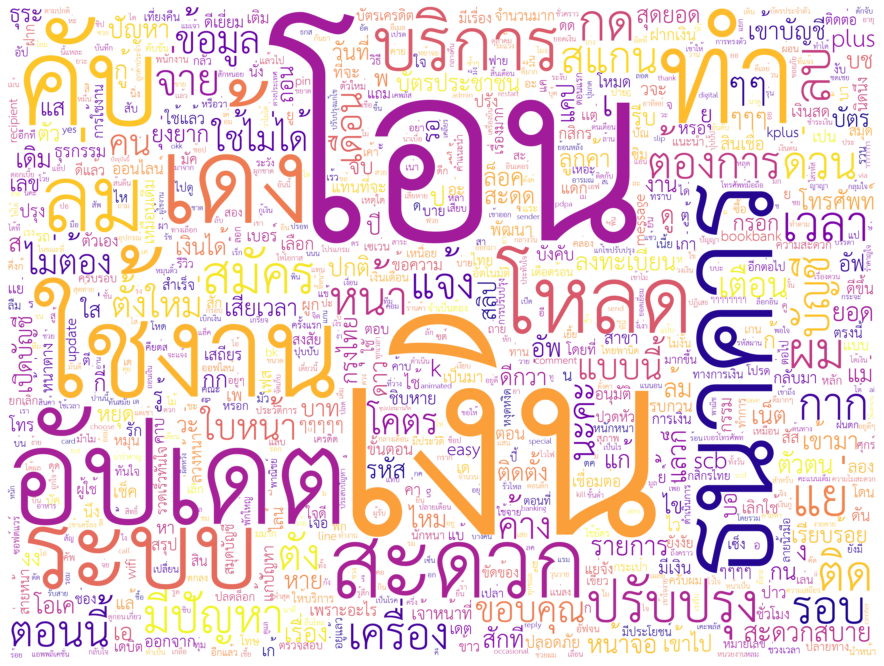

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

In [ ]:
print(wordcloud.words_.keys())

dict_keys(['เงิน', 'โอน', 'อัปเดต', 'ธนาคาร', 'ทำ', 'ใช้งาน', 'คับ', 'เด้ง', 'ระบบ', 'สะดวก', 'โหลด', 'ล่ม', 'บริการ', 'ปรับปรุง', 'แย่', 'สมัคร', 'กด', 'ผม', 'ติด', 'ลบ', 'เวลา', 'มีปัญหา', 'หน้า', 'ด่วน', 'กาก', 'รอบ', 'เครื่อง', 'ต้องการ', 'สแกน', 'ตอนนี้', 'บัญชี', 'จ่าย', 'ตัง', 'แจ้ง', 'ข้อมูล', 'ค้าง', 'ใบหน้า', 'แบบนี้', 'ขอบคุณ', 'เ', 'นะคะ', 'โคตร', 'คน', 'เดือน', 'ตั้งใหม่', 'ใช้ไม่ได้', 'เตือน', 'ไม่ต้อง', 'ๆๆ', 'สะดวกสบาย', 'ง', 'รายการ', 'อัพ', 'ยอด', 'แล้วก็', 'ป', 'ปัญหา', 'ล้ม', 'เดิม', 'เรื่อง', 'กู้', 'ตัวตน', 'ดู', 'หน้าจอ', 'k', 'plus', 'หาย', 'ปกติ', 'ส', 'ติดตั้ง', 'ล็อค', 'ลงทะเบียน', 'เข้ามา', 'เข้าบัญชี', 'ดาว', 'รหัส', 'ลูกค้า', 'ไหม', 'แก้', 'เน็ต', 'สักที', 'ปี', 'กี่', 'งง', 'สะดุด', 'บัตรประชาชน', 'เงินได้', 'โทรศัพท์', 'พ', 'รีบ', 'รอ', 'บัตร', 'กก', 'scb', 'เปิดบัญชี', 'เสียเวลา', 'สุดยอด', 'ยุ่งยาก', 'ดีกว่า', 'กรุงไทย', 'ธุระ', 'แม่', 'บช', 'แคป', 'โอเค', 'แส', 'กน', 'ก้', 'บาท', 'ยุ', 'เอ', 'สลิป', 'ไข', 'ๆๆๆ', 'รู้', 'หยุด', 'ว่ะ', 'กรอก', 'เลข', 'บ